In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go

## Data Clean Up and Loading

In [28]:
# Clean Dataset and Convert to Pickle File
def clean_data(filename):
    data = pd.read_csv(filename)
    data.drop('ID', axis = 1, inplace=True)
    data.drop('Source', axis = 1, inplace=True)
    data.drop('End_Time', axis = 1, inplace=True)
    data.drop('End_Lat', axis = 1, inplace=True)
    data.drop('End_Lng', axis = 1, inplace=True)
    data.drop('Street', axis = 1, inplace=True)
    data.drop('City', axis = 1, inplace=True)
    data.drop('County', axis = 1, inplace=True)
    data.drop('Zipcode', axis = 1, inplace=True)
    data.drop('Country', axis = 1, inplace=True)
    data.drop('Timezone', axis = 1, inplace=True)
    data.drop('Airport_Code', axis = 1, inplace=True)
    data.drop('Weather_Timestamp', axis = 1, inplace=True)
    data.drop('Wind_Direction', axis = 1, inplace=True)
    data.drop('Amenity', axis = 1, inplace=True)
    data.drop('Nautical_Twilight', axis = 1, inplace=True)
    data.drop('Astronomical_Twilight', axis = 1, inplace=True)
    substring = 'I-'
    data['Start_Index'] = data['Description'].str.find(substring)
    data['Start_Index'] = data['Start_Index'].replace([np.inf, -np.inf, np.nan], -1).astype('int64')
    data['Freeway'] = data.apply(
        lambda row: row['Description'][row['Start_Index']:row['Start_Index'] + 5] if row['Start_Index'] != -1 else "O", 
        axis=1
    )

    data['Freeway'] = data['Freeway'].str.replace(' ', '', regex=True)
    data['Is_Freeway'] = data['Start_Index'].apply(lambda x: True if x >= 0 else False)

    data.drop('Start_Index', axis = 1, inplace=True)
    data.drop('Description', axis = 1, inplace=True)
    data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
    data['Is_Day'] = data['Civil_Twilight'].str.contains("Day")
    data.drop('Civil_Twilight', axis = 1, inplace=True)

    data['Severity'] = data['Severity'].astype('int8')
    data['Start_Lat'] = data['Start_Lat'].astype('float16')
    data['Start_Lng'] = data['Start_Lng'].astype('float16')
    data['Distance(mi)'] = data['Distance(mi)'].astype('float16')
    data['Temperature(F)'] = data['Temperature(F)'].astype('float16')
    data['Wind_Chill(F)'] = data['Wind_Chill(F)'].astype('float16')
    data['Humidity(%)'] = data['Humidity(%)'].astype('float16')
    data['Pressure(in)'] = data['Pressure(in)'].astype('float16')
    data['Visibility(mi)'] = data['Visibility(mi)'].astype('float16')
    data['Wind_Speed(mph)'] = data['Wind_Speed(mph)'].astype('float16')
    data['Precipitation(in)'] = data['Precipitation(in)'].astype('float16')

    data.to_pickle('clean_data.pkl')
    return data

In [29]:
def load_data_from_pickle(filename):
    df = pd.read_pickle(filename)
    return df
def load_data(file_path):
    return pd.read_csv(file_path)


In [30]:
pickle_file_path = "/home/surya/Desktop/FA24/ECE143_Python/Final_Project/US_Car_Accident_Data_Analysis/Dataset/clean_data.pkl"
file_path = "/home/surya/Desktop/FA24/ECE143_Python/Final_Project/US_Car_Accident_Data_Analysis/Dataset/US_Accidents_March23.csv"
df = load_data(file_path)

## All Functions


In [31]:
# Clean weather-related columns
def clean_weather_data(df):
    weather_cols = ['Start_Time', 'Start_Lng', 'Sunrise_Sunset', 'Start_Lat', 'Weather_Condition', 'Temperature(F)', 'Wind_Speed(mph)', 
                    'Visibility(mi)', 'Precipitation(in)', 'Humidity(%)', 'Severity']
    df = df[weather_cols].dropna()
    return df

def filter_severe_accidents(df):
    # Ensure 'Severity' column exists
    if 'Severity' in df.columns:
        # Filter the DataFrame to include only severe accidents with Severity 3 or 4
        severe_df = df[df['Severity'].isin([3, 4])]
        return severe_df
    else:
        raise KeyError("The DataFrame does not contain a 'Severity' column.")

def analyze_weather_vs_severity(df):
    # Group by 'Weather_Condition' and sum up the accident counts
    weather_counts = df['Weather_Condition'].value_counts().nlargest(8)
    
    # Filter the original DataFrame to include only the top 8 weather conditions
    top_weather_conditions = weather_counts.index
    filtered_df = df[df['Weather_Condition'].isin(top_weather_conditions)]
    
    # Group by 'Weather_Condition' and 'Severity', then unstack
    weather_severity = filtered_df.groupby(['Weather_Condition', 'Severity']).size().unstack(fill_value=0)
    
    # Plot the data
    weather_severity.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title("Impact of Weather Conditions on Accident Severity")
    plt.xlabel("Weather Condition")
    plt.ylabel("Accident Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_temperature_ranges(df):
    bins = [-10, 32, 50, 70, 90, 120]
    labels = ['Very Cold', 'Cold', 'Moderate', 'Warm', 'Hot']
    df['Temp_Range'] = pd.cut(df['Temperature(F)'], bins=bins, labels=labels)
    temp_counts = df['Temp_Range'].value_counts().sort_index()
    temp_counts.plot(kind='bar', color='skyblue', figsize=(8, 5))
    plt.title("Accidents by Temperature Range")
    plt.xlabel("Temperature Range")
    plt.ylabel("Accident Count")
    plt.tight_layout()
    plt.show()

def analyze_weather_time_of_day(df):
    # Convert 'Start_Time' to datetime, coercing errors to NaT
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    
    # Drop rows where 'Start_Time' conversion resulted in NaT
    df = df.dropna(subset=['Start_Time'])
    
    # Extract the hour from 'Start_Time'
    df['Hour'] = df['Start_Time'].dt.hour
    
    # Determine the top 5 weather conditions by accident count
    top_weather_conditions = df['Weather_Condition'].value_counts().nlargest(5).index
    
    # Filter the DataFrame to include only the top 5 weather conditions
    df_top_weather = df[df['Weather_Condition'].isin(top_weather_conditions)]
    
    # Group by 'Weather_Condition' and 'Hour', then unstack
    weather_hour = df_top_weather.groupby(['Weather_Condition', 'Hour']).size().unstack(fill_value=0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(weather_hour, cmap="YlGnBu", linewidths=0.5)
    plt.title("Accidents by Top 5 Weather Conditions and Time of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Weather Condition")
    plt.tight_layout()
    plt.show()

def analyze_visibility(df):
    # Define bins and labels for visibility ranges
    bins = [0, 1, 3, 5, 10, 20, 50]
    labels = ['Very Low', 'Low', 'Moderate', 'Good', 'Very Good', 'Excellent']
    
    # Create a new column 'Visibility_Range' based on the bins
    df['Visibility_Range'] = pd.cut(df['Visibility(mi)'], bins=bins, labels=labels)
    
    # Count the number of accidents in each visibility range
    visibility_counts = df['Visibility_Range'].value_counts().sort_index()
    
    # Plot the results
    plt.figure(figsize=(8, 5))
    visibility_counts.plot(kind='bar', color='purple')
    plt.title("Accidents by Visibility Range")
    plt.xlabel("Visibility Range")
    plt.ylabel("Accident Count")
    plt.tight_layout()
    plt.show()

def analyze_precipitation(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Precipitation(in)', y='Severity', data=df, alpha=0.5)
    plt.title("Precipitation vs. Accident Severity")
    plt.xlabel("Precipitation (in)")
    plt.ylabel("Severity")
    plt.tight_layout()
    plt.show()

def wind_speed_analysis(df):
   if 'Wind_Speed(mph)' in df.columns:
        wind_speed_severity = df.groupby(pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30])).Severity.mean()
        
        wind_speed_severity.plot(kind='bar', color='skyblue')

        plt.title('Impact of Wind Speed on Accident Severity')
        plt.xlabel('Wind Speed (mph)')
        plt.ylabel('Average Severity')

        plt.tight_layout()

        plt.show()

def map_weather_conditions(df):
    # Convert DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Start_Lng'], df['Start_Lat']))

    # Create a new plot with Cartopy
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add natural features like coastlines and borders
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot accident points on top of the map
    gdf.plot(ax=ax, color='blue', alpha=0.5, markersize=1, transform=ccrs.PlateCarree())

    plt.title("Geospatial Distribution of Accidents by Weather Condition")
    plt.tight_layout()
    plt.show()

def analyze_monthly_accidents(df):
    # Convert 'Start_Time' to datetime, coercing errors to NaT
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    
    # Drop rows where 'Start_Time' conversion resulted in NaT
    df = df.dropna(subset=['Start_Time'])
    
    df['Month'] = pd.to_datetime(df['Start_Time']).dt.month
    monthly_counts = df.groupby('Month').size()
    monthly_severity = df.groupby('Month')['Severity'].mean()

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(monthly_counts.index, monthly_counts.values, color='b', alpha=0.6, label='Number of Accidents')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Accidents', color='b')
    
    ax2 = ax1.twinx()
    ax2.plot(monthly_severity.index, monthly_severity.values, color='r', marker='o', label='Average Severity')
    ax2.set_ylabel('Average Severity', color='r')

    plt.title('Monthly Analysis of Accidents and Severity')
    fig.tight_layout()
    plt.show()

def daily_accident_trends(df):
    df['Date'] = pd.to_datetime(df['Start_Time']).dt.date
    daily_counts = df.groupby('Date').size()

    plt.figure(figsize=(14, 6))
    daily_counts.plot()
    plt.title('Daily Accident Trends')
    plt.xlabel('Date')
    plt.ylabel('Number of Accidents')
    plt.tight_layout()
    plt.show()

def weather_correlation_matrix(df):
    weather_data = df[['Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Severity']]
    corr_matrix = weather_data.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Weather Features and Severity')
    plt.tight_layout()
    plt.show()

def boxplot_weather_severity(df):
    # Determine the top 10 weather conditions by accident count
    top_weather_conditions = df['Weather_Condition'].value_counts().nlargest(10).index

    # Filter the DataFrame to include only the top 10 weather conditions
    df_top_weather = df[df['Weather_Condition'].isin(top_weather_conditions)]

    # Create the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Weather_Condition', y='Severity', data=df_top_weather)

    plt.xticks(rotation=45)
    plt.title('Severity Distribution Across Top 10 Weather Conditions')
    plt.tight_layout()
    plt.show()

def boxplot_worst_weather_severity(df):
    # Define a list of known hazardous weather conditions
    worst_weather_conditions = [
        'Rain', 'Snow', 'Sleet', 'Fog', 'Ice', 'Hail', 'Thunderstorm', 
        'Blizzard', 'Freezing Rain', 'Heavy Rain'
    ]
    
    # Filter the DataFrame to include only these worst weather conditions
    df_worst_weather = df[df['Weather_Condition'].isin(worst_weather_conditions)]

    # Create the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Weather_Condition', y='Severity', data=df_worst_weather)
    
    plt.xticks(rotation=45)
    plt.title('Severity Distribution Across Worst Weather Conditions')
    plt.tight_layout()
    plt.show()

def day_night_accident_comparison(df):
   if 'Sunrise_Sunset' in df.columns:
        day_night_counts = df.groupby(['Sunrise_Sunset']).size()

        day_night_counts.plot(kind='bar', color=['orange', 'navy'])

        plt.title('Day vs Night Accidents by Weather Condition')

        plt.xlabel('Time of Day')

        plt.ylabel('Number of Accidents')

        plt.xticks(rotation=0)

        plt.tight_layout()

        plt.show()

def temperature_humidity_interaction(df):
   if 'Humidity(%)' in df.columns:
        # Construct dataset for plotting
        temp_humidity_df = df[['Temperature(F)', 'Humidity(%)', 'Severity']]

        # Create a joint plot with hexagonal bins
        plt.figure(figsize=(10, 7))
        joint_plot = sns.jointplot(x='Temperature(F)', y='Humidity(%)', data=temp_humidity_df, kind='hex', gridsize=30)

        # Set titles and labels
        joint_plot.fig.suptitle('Joint Analysis of Temperature and Humidity Effects on Accident Severity', y=1.05)
        joint_plot.set_axis_labels('Temperature (°F)', 'Humidity (%)')

        # Add a color bar indicating point density
        plt.colorbar(label='Point Density')

        plt.tight_layout()
        plt.show()

def severity_distribution_map(df):
   if {'Start_Lng', 'Start_Lat'}.issubset(df.columns):
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Start_Lng'], df['Start_Lat']))

        fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

        ax.add_feature(cfeature.COASTLINE)

        ax.add_feature(cfeature.BORDERS)

        gdf.plot(ax=ax, column='Severity', cmap='OrRd', legend=True, markersize=5)

        ax.set_title("Severity Distribution by Region")

        ax.set_extent([-130, -65, 20, 55]) # Rough extent for continental US
        
        fig.tight_layout()

        plt.show()


In [32]:
# Create data subset
df_weather = clean_weather_data(df)
df_severe = filter_severe_accidents(df)

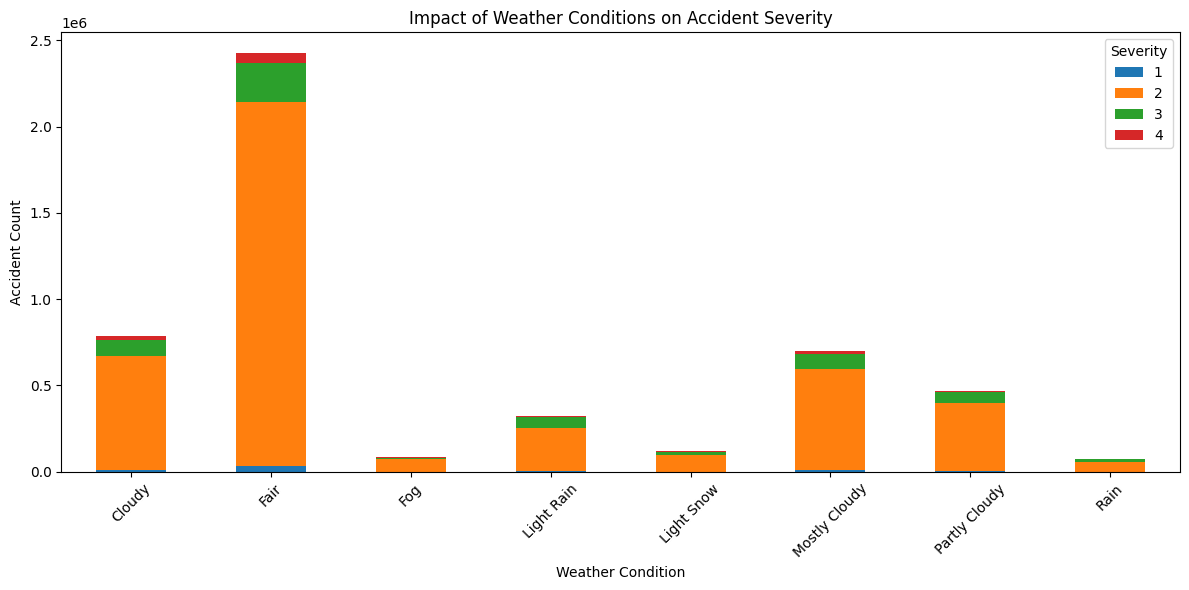

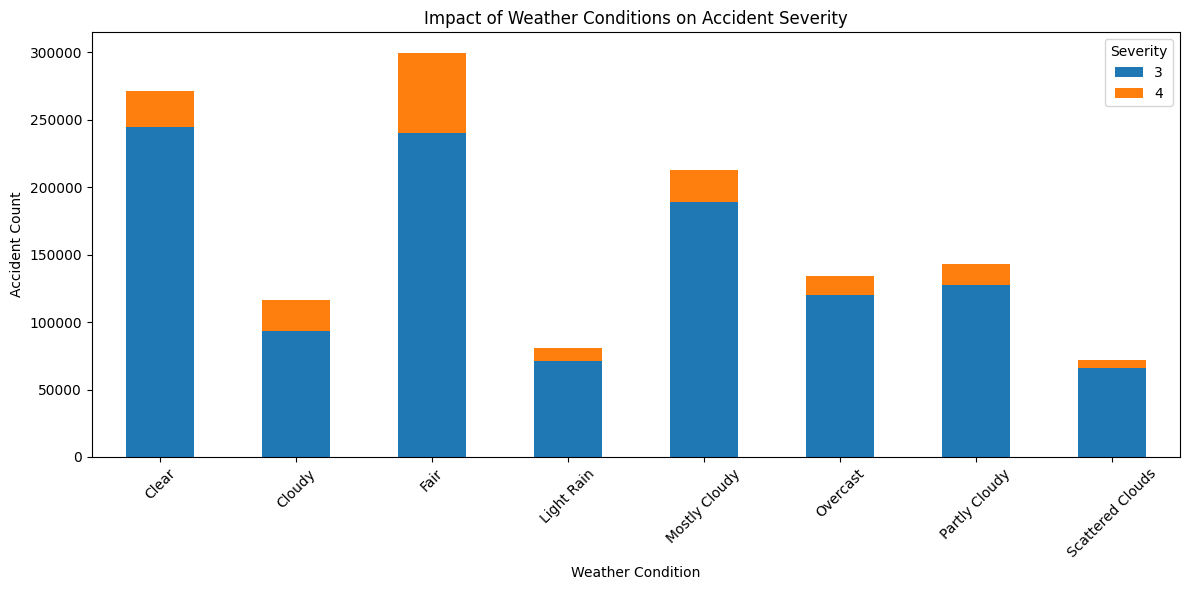

In [33]:
analyze_weather_vs_severity(df_weather)
analyze_weather_vs_severity(df_severe)

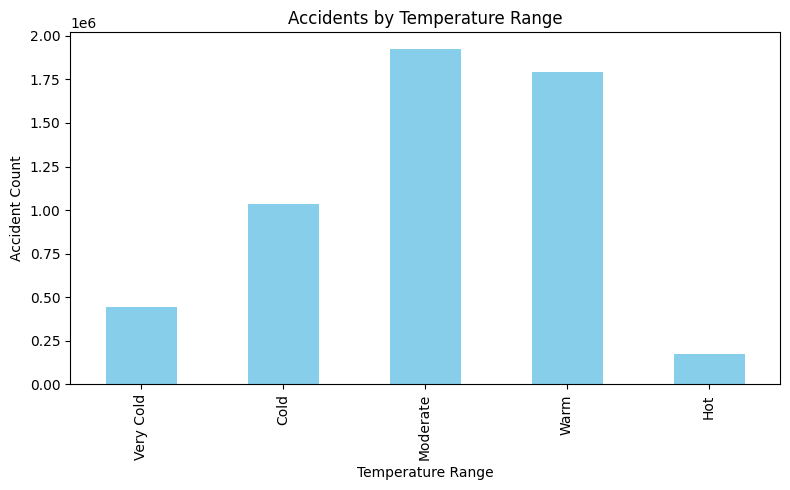

/tmp/ipykernel_11961/2470827022.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temp_Range'] = pd.cut(df['Temperature(F)'], bins=bins, labels=labels)


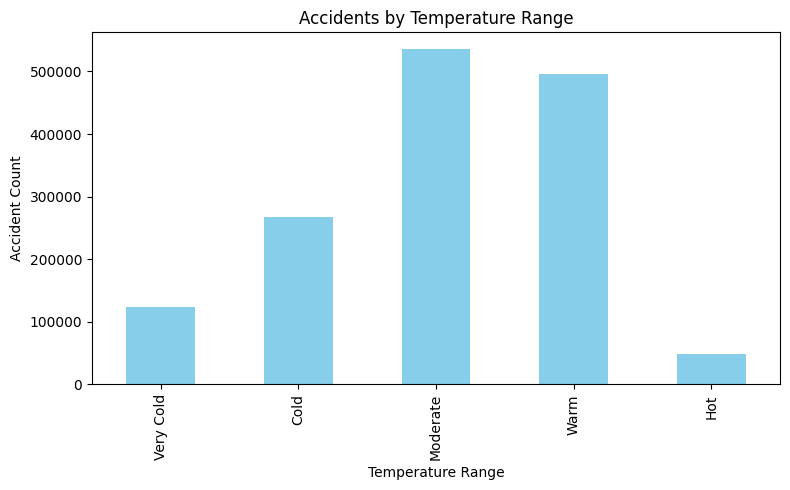

In [34]:
analyze_temperature_ranges(df_weather)
analyze_temperature_ranges(df_severe)

/tmp/ipykernel_11961/2470827022.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Start_Time'].dt.hour


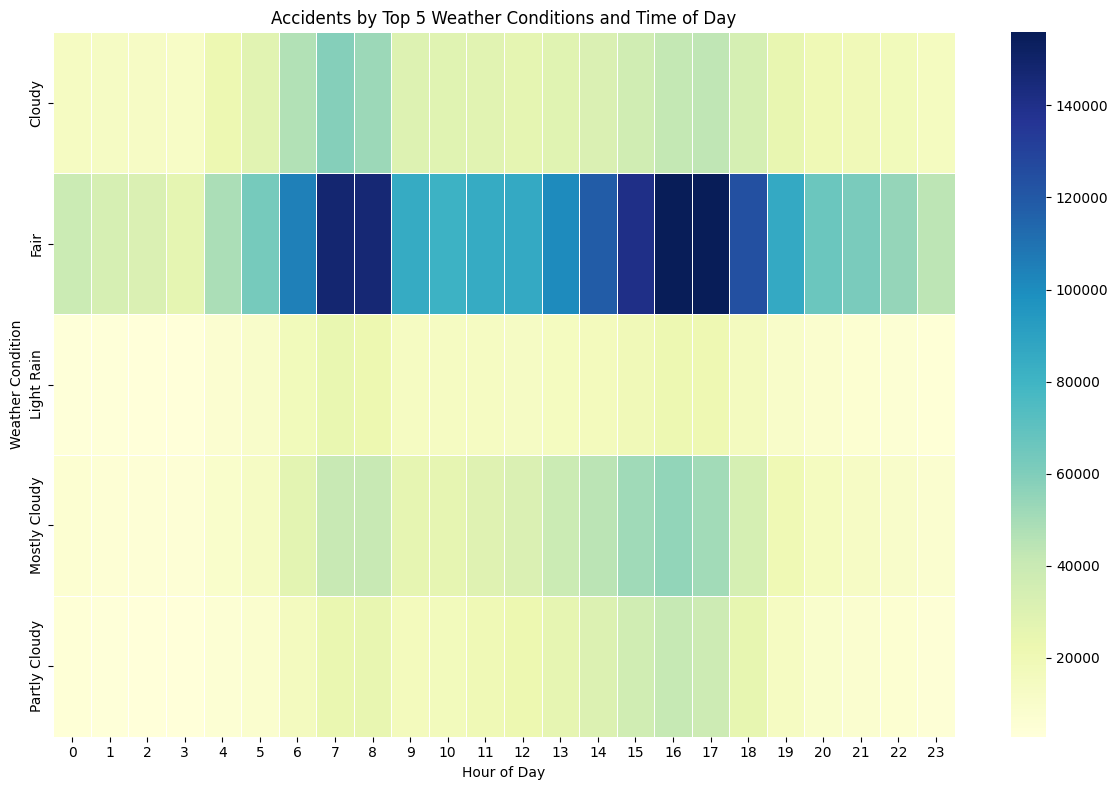

/tmp/ipykernel_11961/2470827022.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
/tmp/ipykernel_11961/2470827022.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour'] = df['Start_Time'].dt.hour


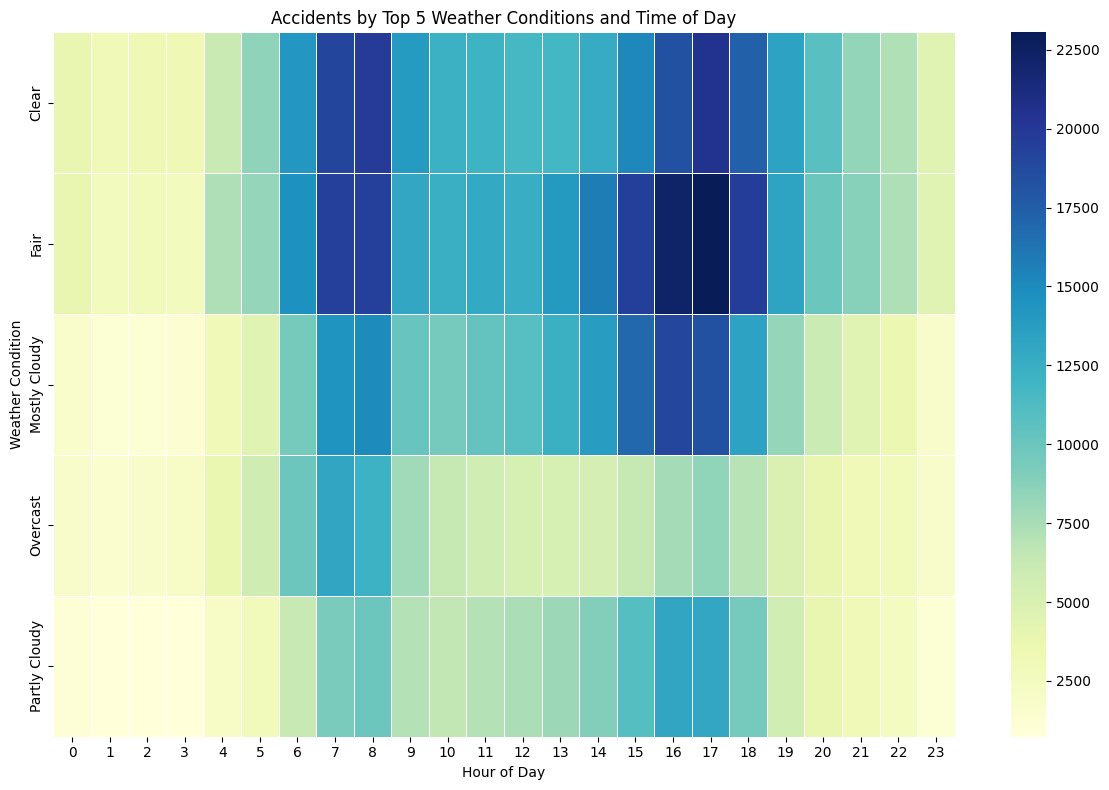

In [35]:
analyze_weather_time_of_day(df_weather)
analyze_weather_time_of_day(df_severe)

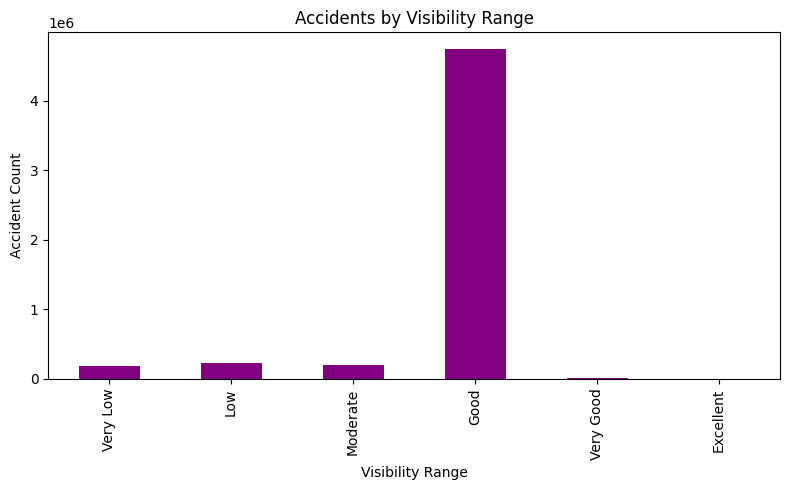

/tmp/ipykernel_11961/2470827022.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Visibility_Range'] = pd.cut(df['Visibility(mi)'], bins=bins, labels=labels)


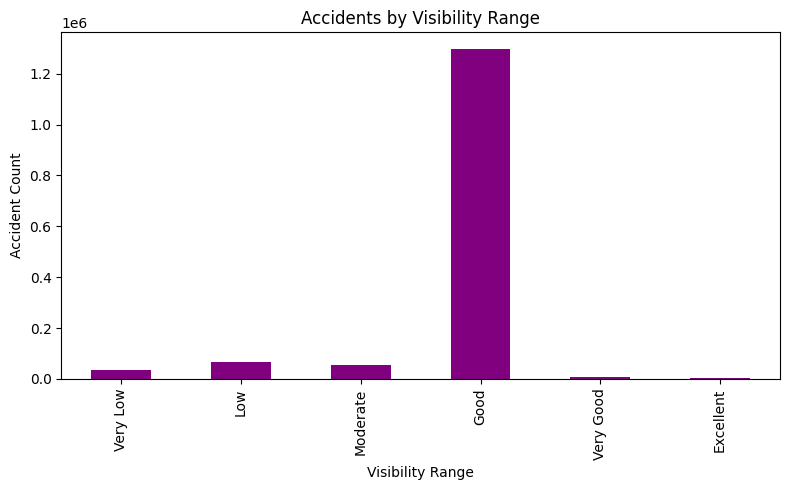

In [36]:
analyze_visibility(df_weather)
analyze_visibility(df_severe)

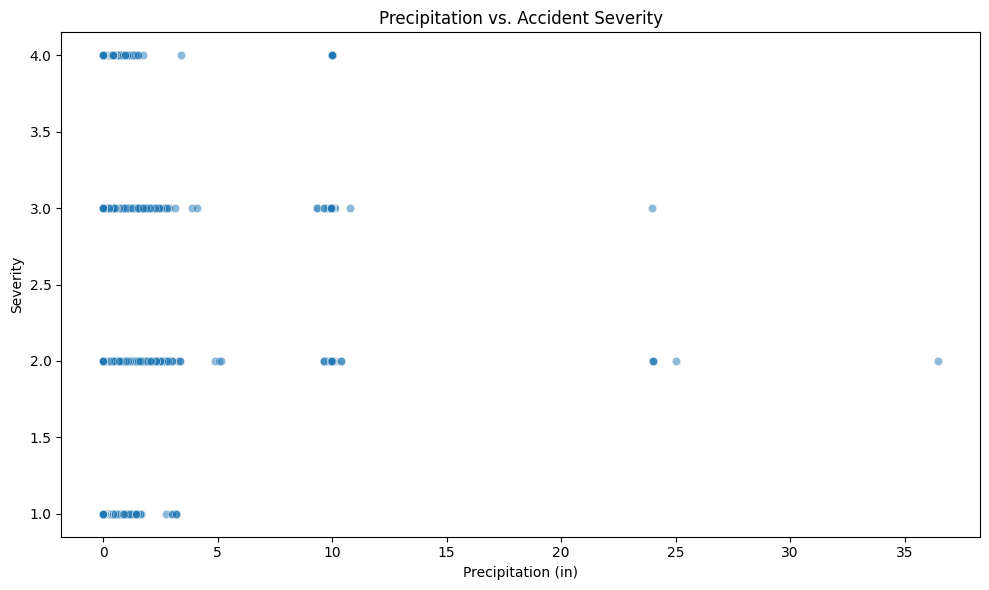

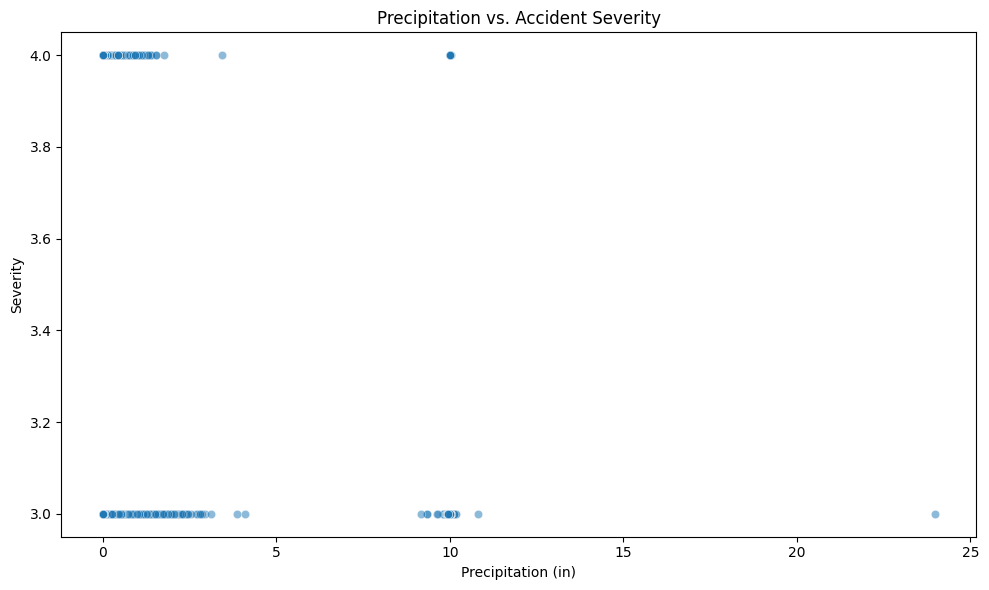

In [37]:
analyze_precipitation(df_weather)
analyze_precipitation(df_severe)

/tmp/ipykernel_11961/2470827022.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_speed_severity = df.groupby(pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30])).Severity.mean()


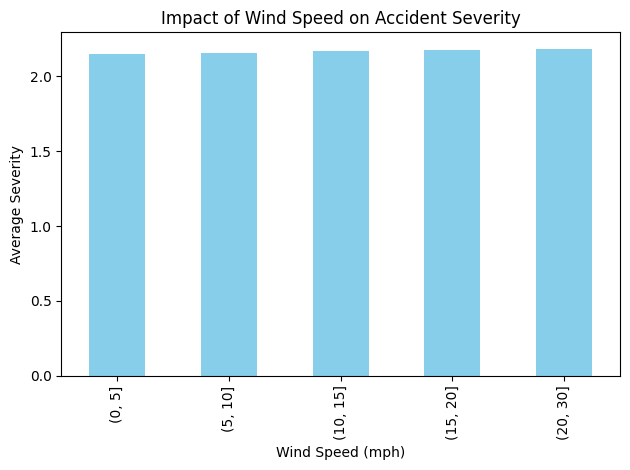

/tmp/ipykernel_11961/2470827022.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_speed_severity = df.groupby(pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30])).Severity.mean()


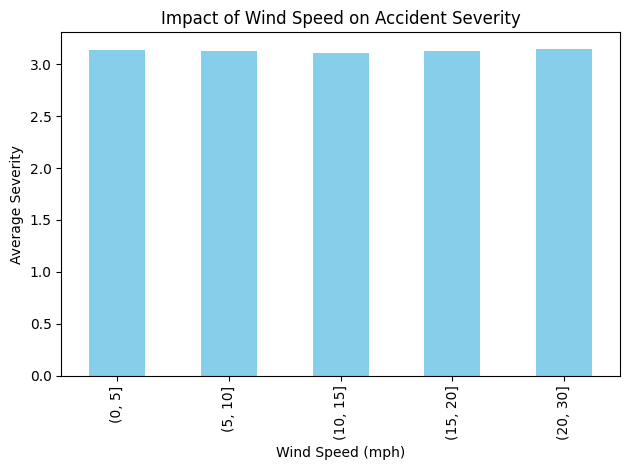

In [38]:
wind_speed_analysis(df_weather)
wind_speed_analysis(df_severe)

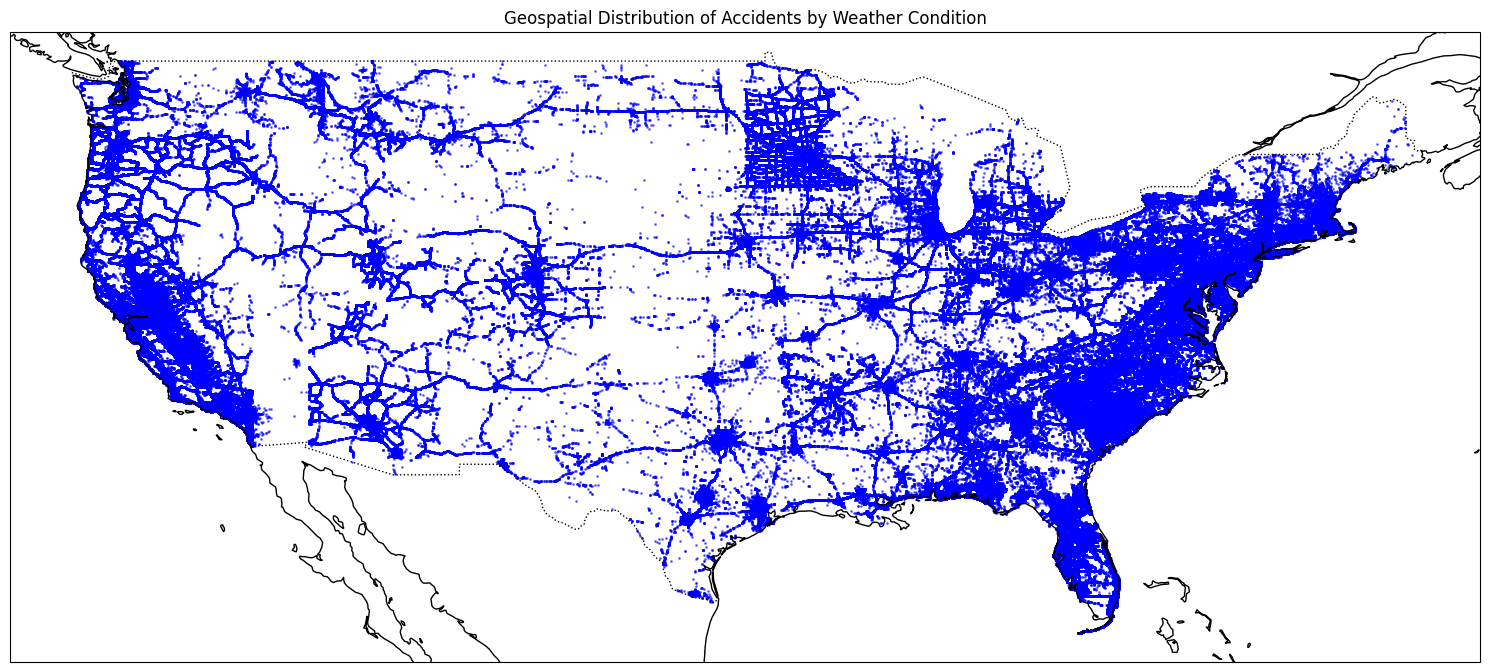

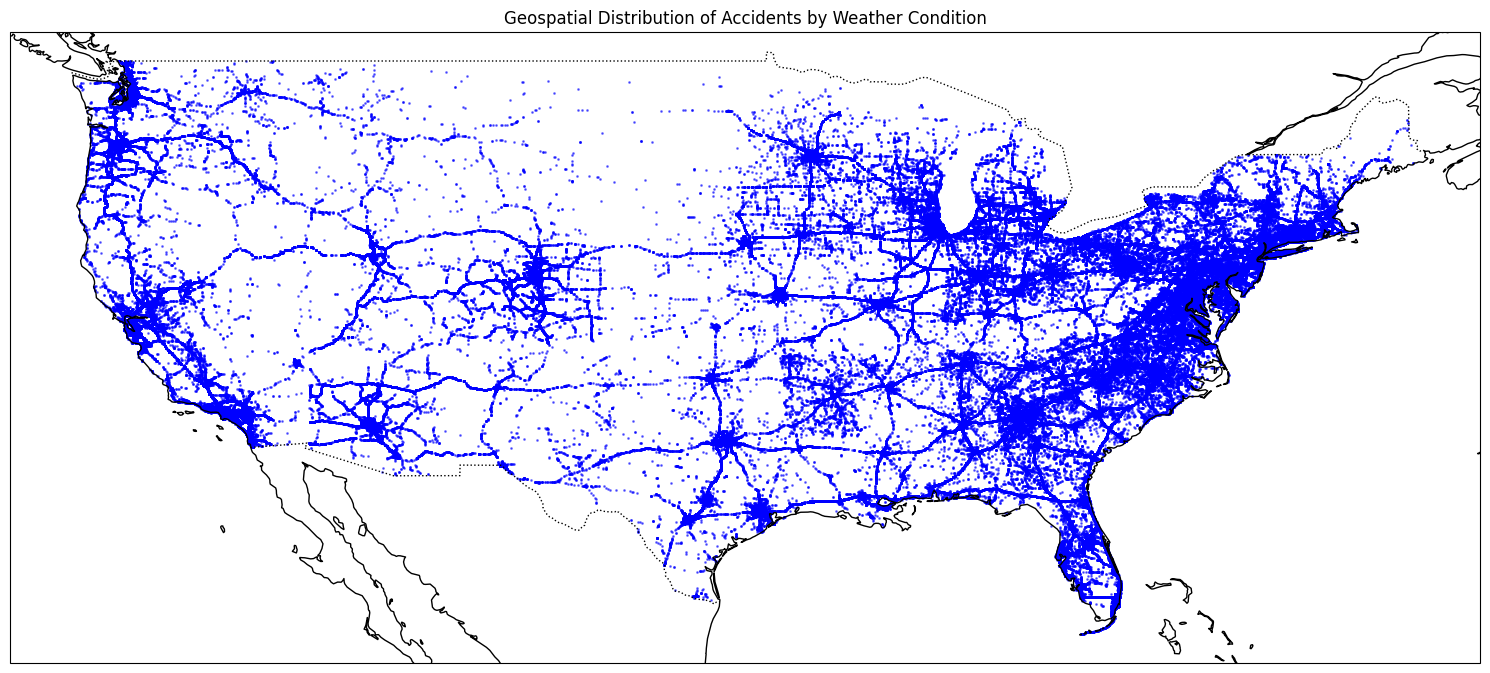

In [39]:
map_weather_conditions(df_weather)
map_weather_conditions(df_severe)

/tmp/ipykernel_11961/2470827022.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = pd.to_datetime(df['Start_Time']).dt.month


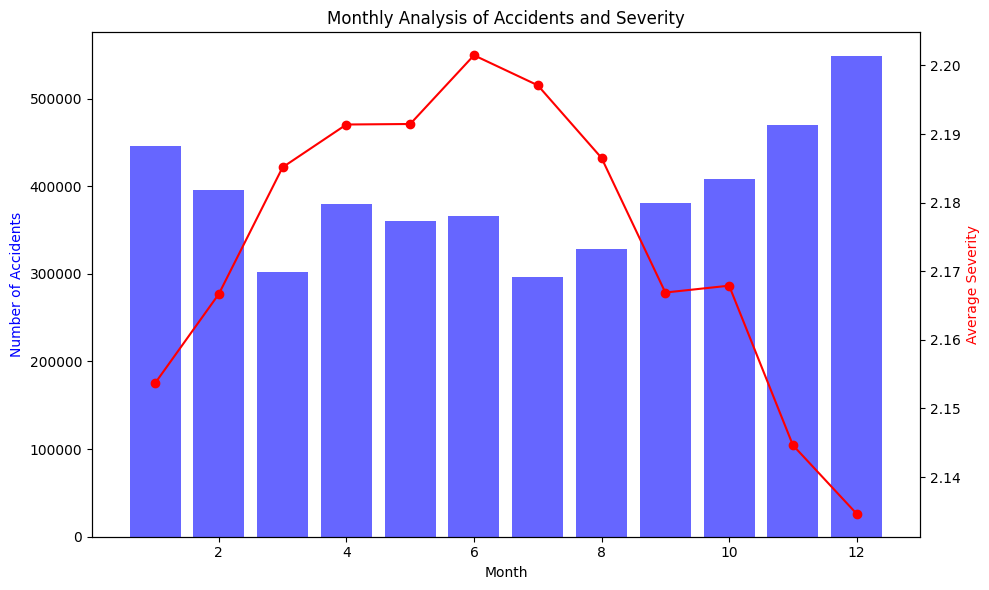

/tmp/ipykernel_11961/2470827022.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
/tmp/ipykernel_11961/2470827022.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = pd.to_datetime(df['Start_Time']).dt.month


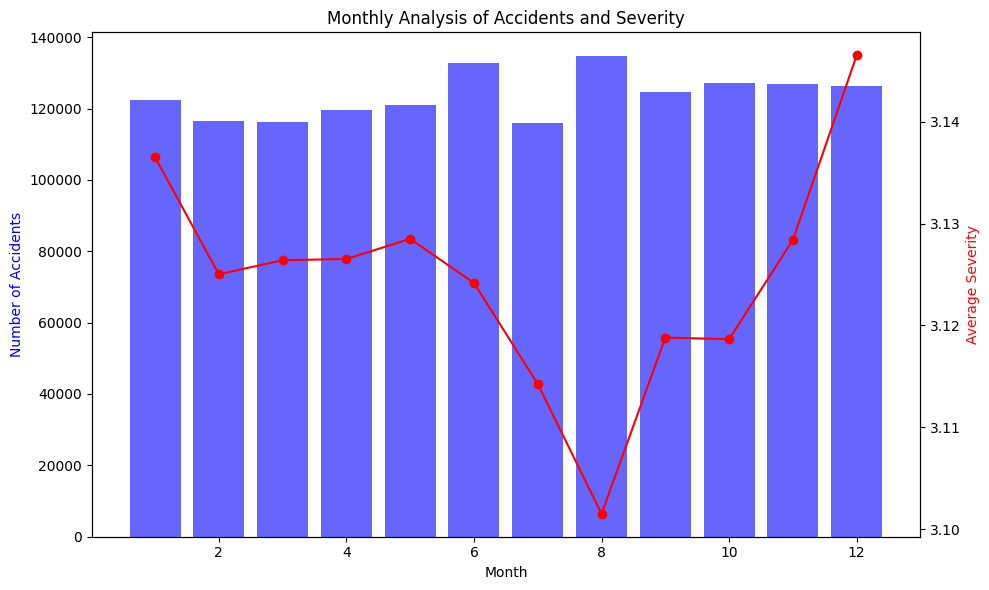

In [40]:
analyze_monthly_accidents(df_weather)
analyze_monthly_accidents(df_severe)

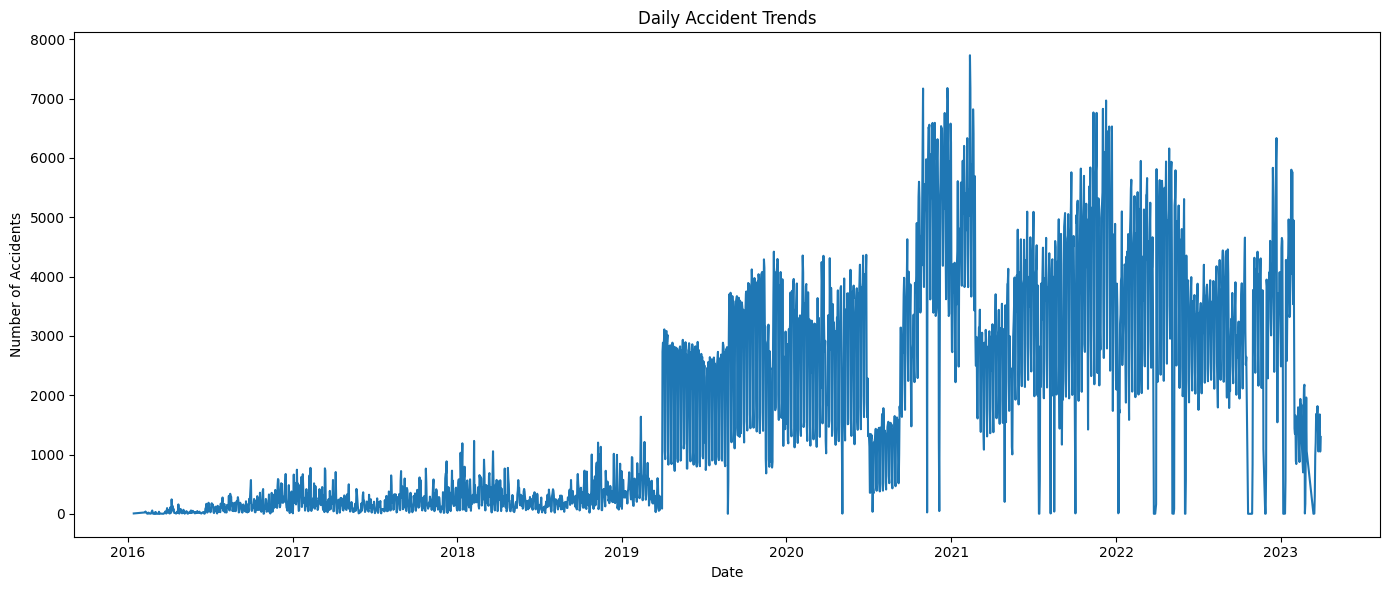

/tmp/ipykernel_11961/2470827022.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Start_Time']).dt.date


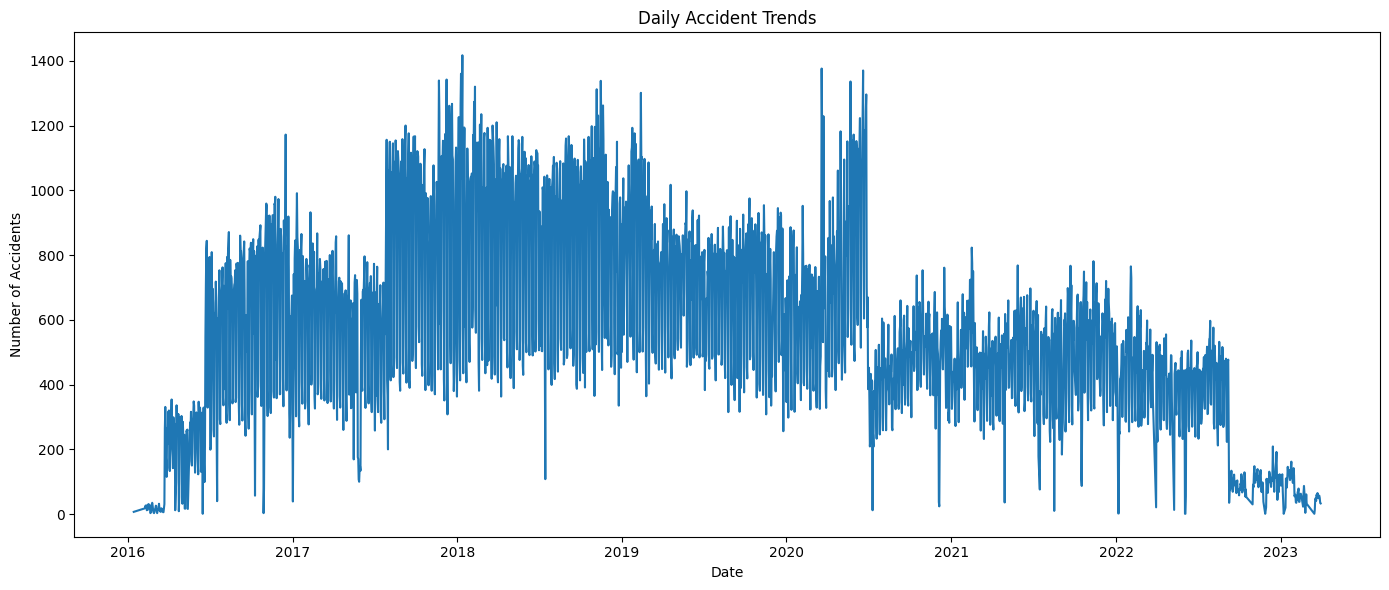

In [41]:
daily_accident_trends(df_weather)
daily_accident_trends(df_severe)

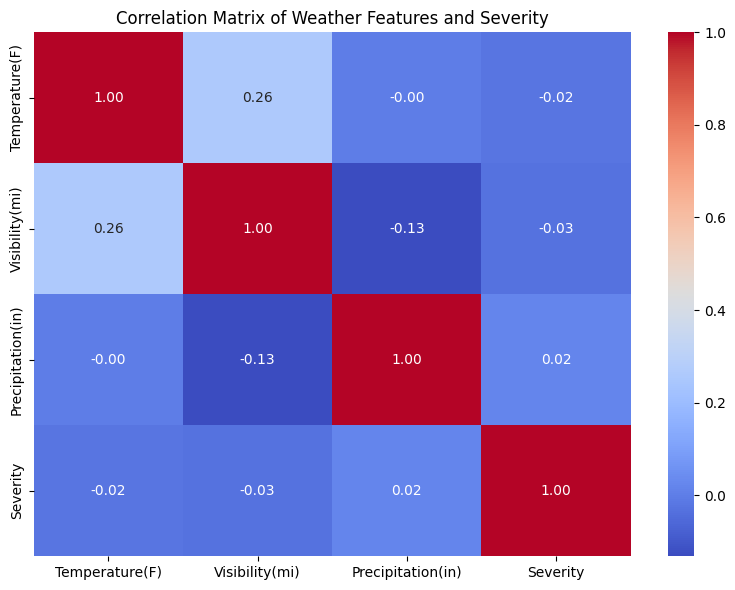

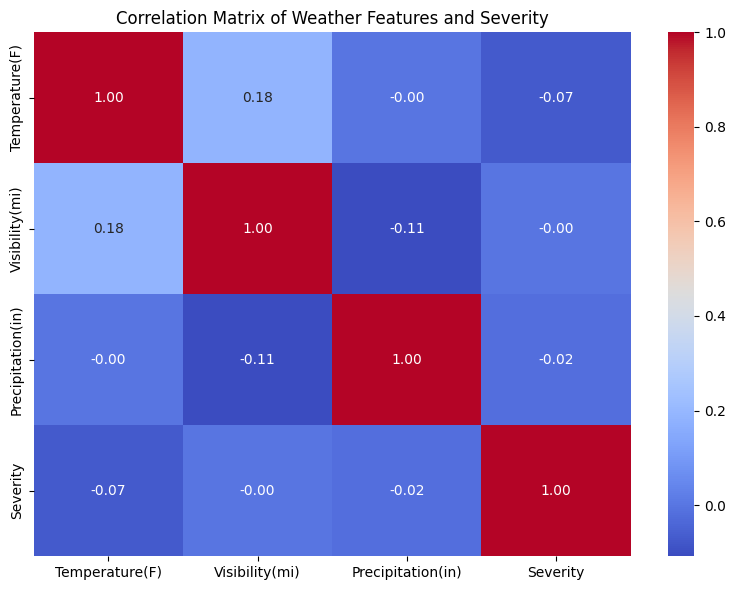

In [42]:
weather_correlation_matrix(df_weather)
weather_correlation_matrix(df_severe)

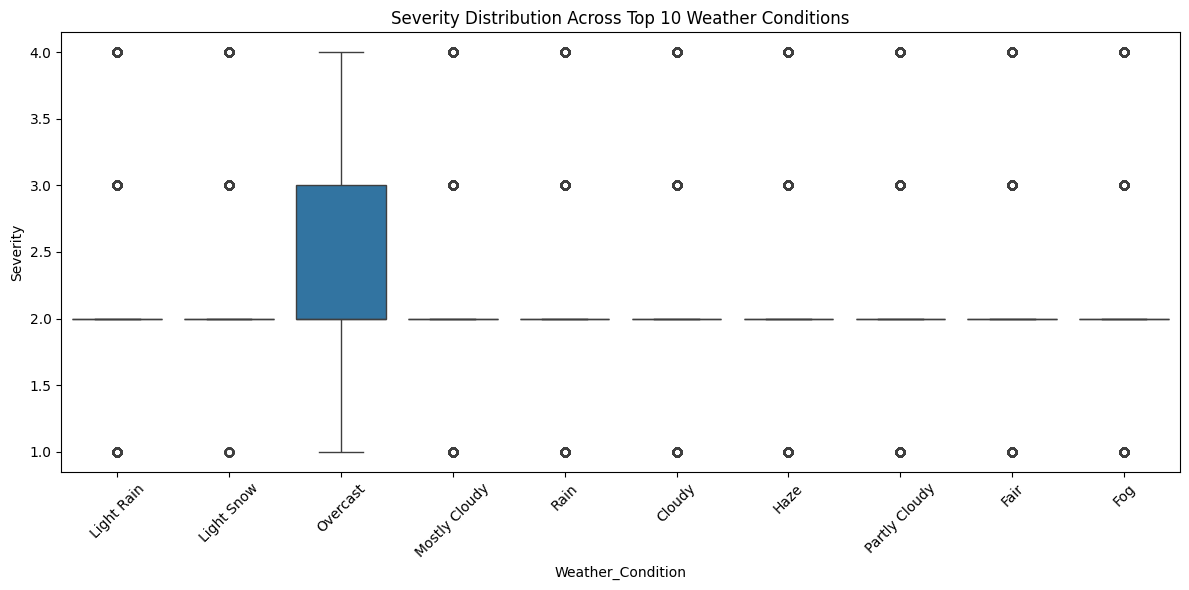

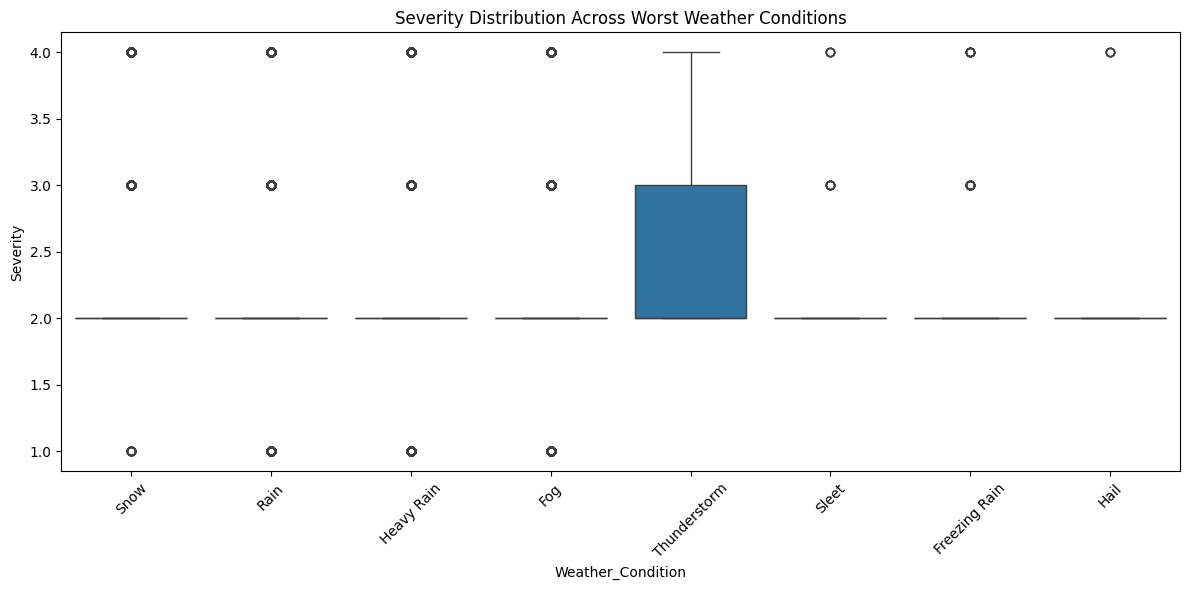

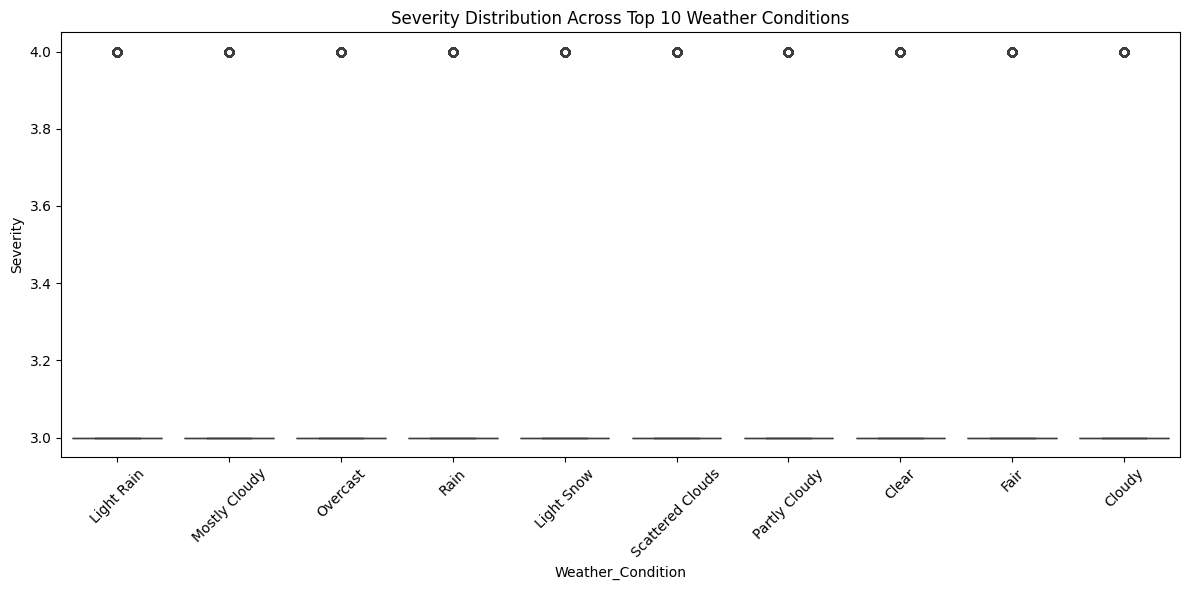

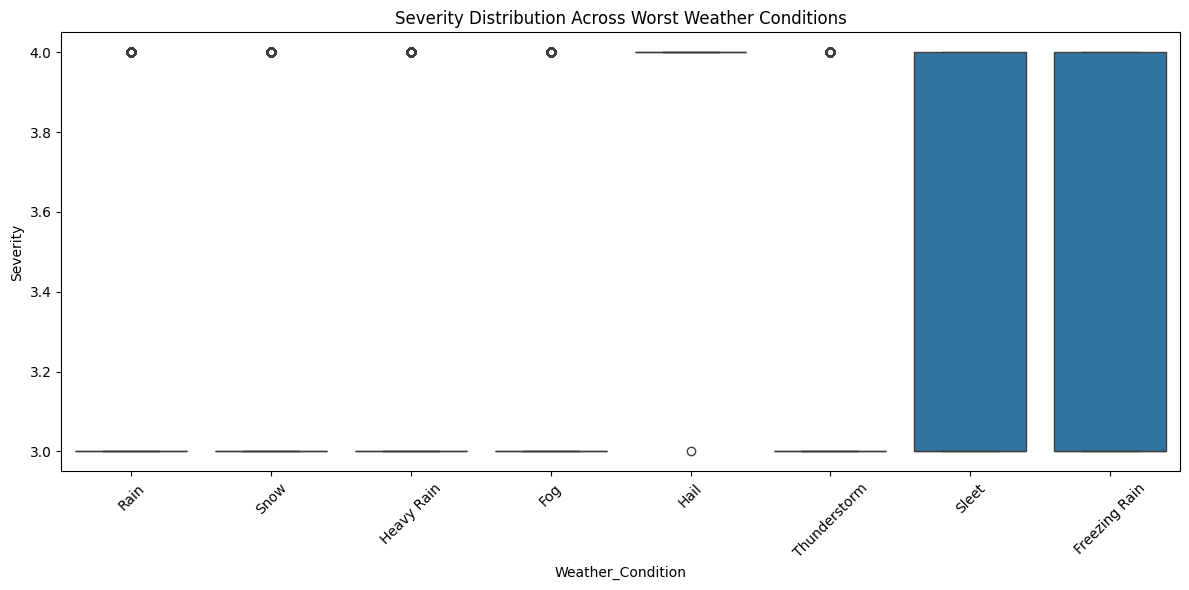

In [43]:
boxplot_weather_severity(df_weather)
boxplot_worst_weather_severity(df_weather)

boxplot_weather_severity(df_severe)
boxplot_worst_weather_severity(df_severe)

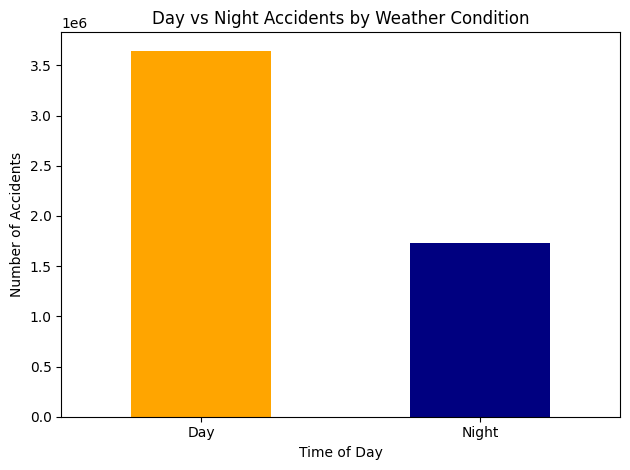

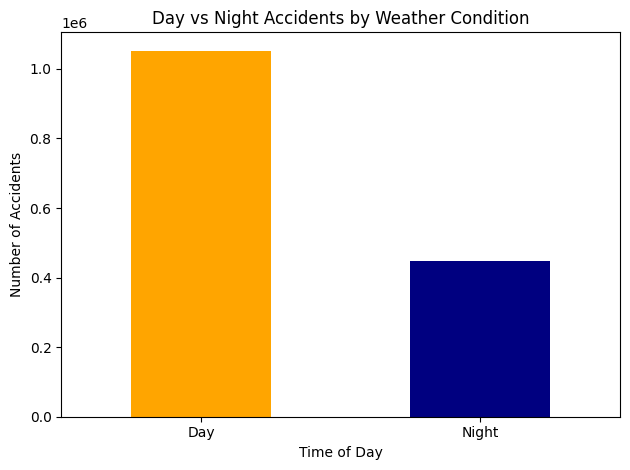

In [44]:
day_night_accident_comparison(df_weather)
day_night_accident_comparison(df_severe)

<Figure size 1000x700 with 0 Axes>

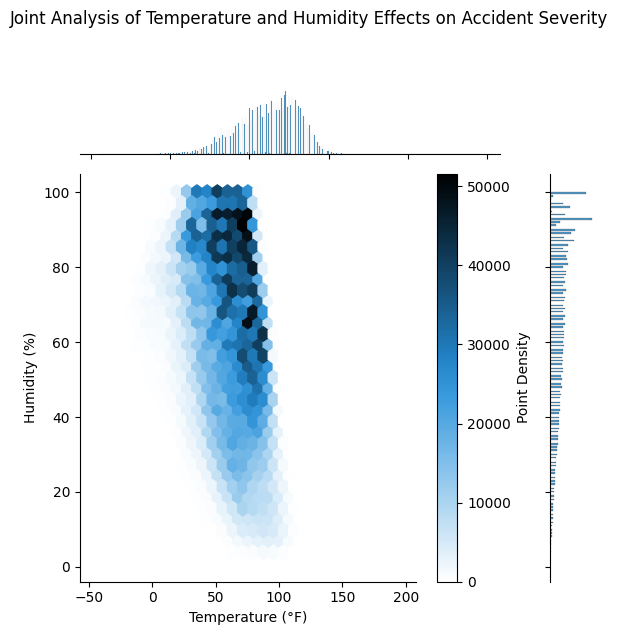

<Figure size 1000x700 with 0 Axes>

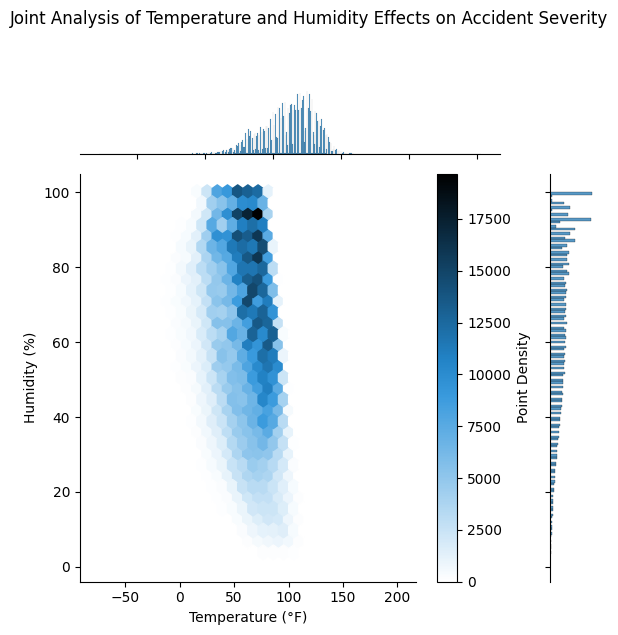

In [45]:
temperature_humidity_interaction(df_weather)
temperature_humidity_interaction(df_severe)

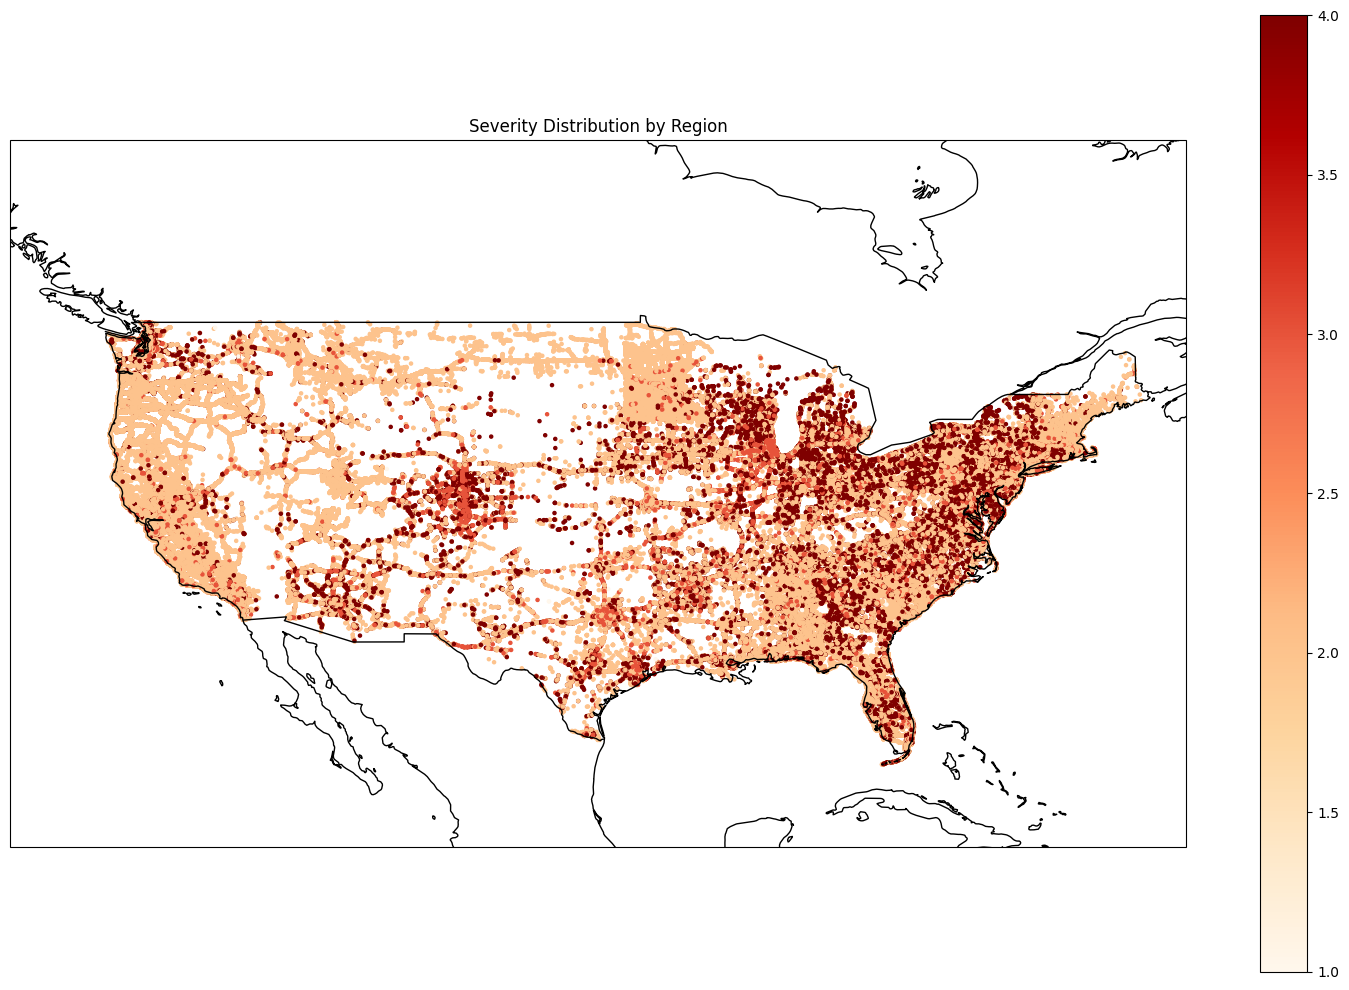

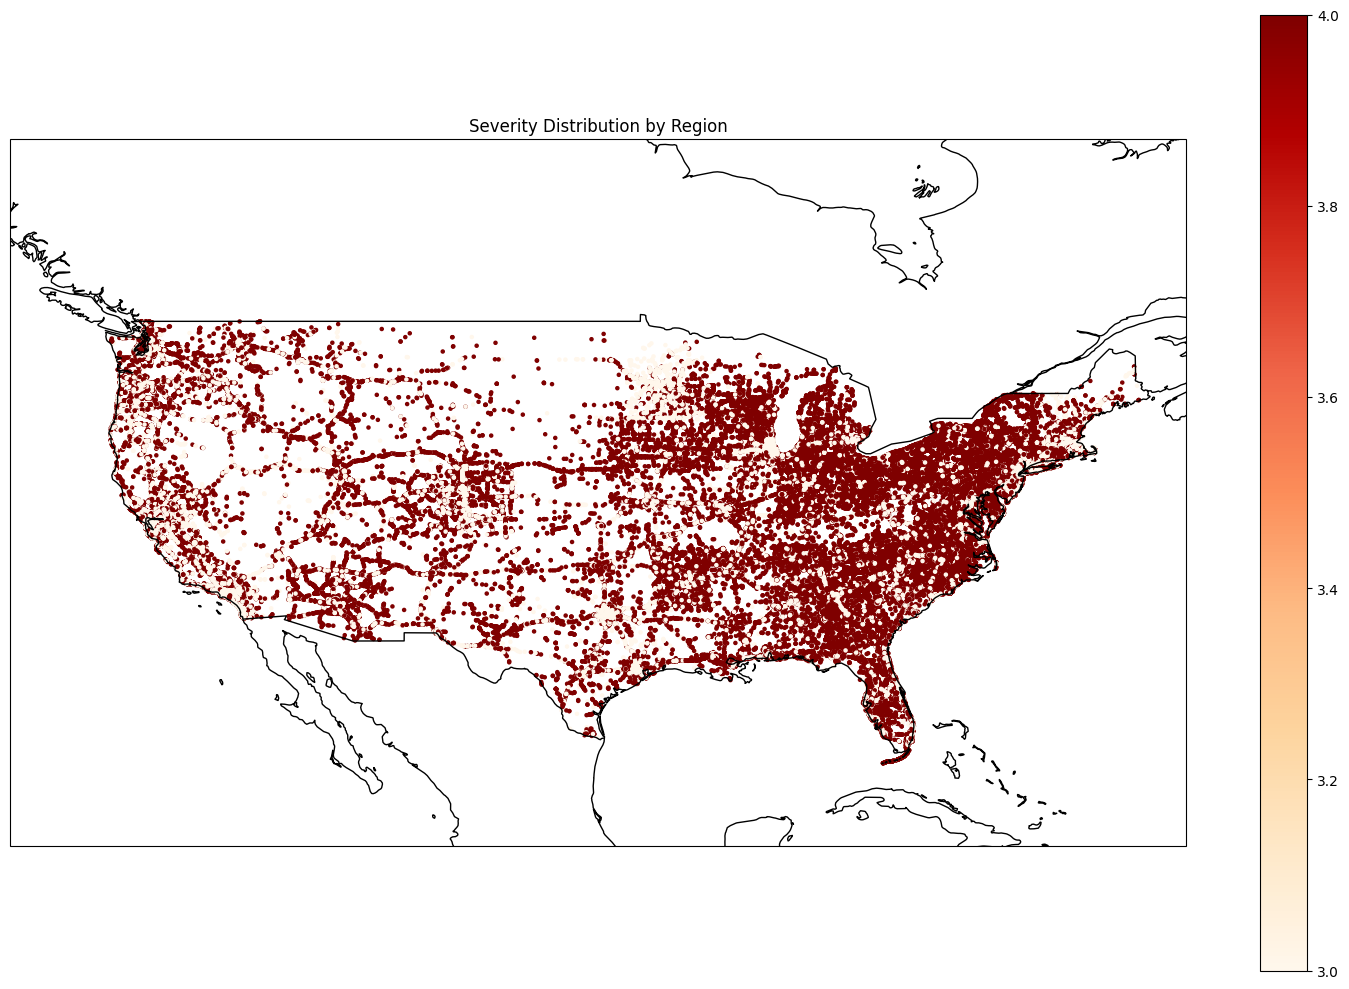

In [46]:
severity_distribution_map(df_weather)
severity_distribution_map(df_severe)

In [47]:
def plot_accidents_and_severity(df, time_column, title, x_labels=None):
    """
    绘制事故数量和严重性双轴图
    
    参数:
    - df: 数据表
    - time_column: 时间列名（如 'Year', 'Month', 'Hour'）
    - title: 图表标题
    - x_labels: X轴标签（可选）
    """
    # 准备事故数量数据
    counts = df[time_column].value_counts().sort_index().reset_index(name='Counts')
    counts.columns = [time_column, 'Counts']
    
    # 准备事故严重性数据
    severity = df.groupby(time_column)['Severity'].mean().reset_index()
    
    # 合并数据
    merged = pd.merge(counts, severity, on=time_column)
    
    # 创建双轴图
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # 左轴: 事故数量柱状图
    ax1.bar(merged[time_column], merged['Counts'], color='skyblue', alpha=0.7, label='Accidents Count')
    ax1.set_xlabel(time_column.capitalize())
    ax1.set_ylabel('Number of Accidents', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # 添加右轴: 事故严重性折线图
    ax2 = ax1.twinx()
    ax2.plot(merged[time_column], merged['Severity'], color='red', marker='o', label='Average Severity')
    ax2.set_ylabel('Average Severity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 设置标题
    plt.title(title)
    ax1.grid(alpha=0.3)
    
    # 设置X轴标签
    if x_labels:
        ax1.set_xticks(range(1, len(x_labels) + 1))
        ax1.set_xticklabels(x_labels)
    
    # 显示图例
    fig.tight_layout()
    plt.show()

# 主函数：展示年、月、小时的分析图
def analyze_time_vs_severity_and_count(df):
    # 确保 'Start_Time' 是 datetime 类型
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    
    # 提取时间列
    df['Year'] = df['Start_Time'].dt.year
    df['Month'] = df['Start_Time'].dt.month
    df['Hour'] = df['Start_Time'].dt.hour
    
    # 年分析
    plot_accidents_and_severity(df, 'Year', 'Accidents and Severity by Year')
    
    # 月分析
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plot_accidents_and_severity(df, 'Month', 'Accidents and Severity by Month', month_labels)
    
    # 小时分析
    plot_accidents_and_severity(df, 'Hour', 'Accidents and Severity by Hour')

def accident_by_year_severity(df):
        # Ensure 'Start_Time' is in datetime format and extract the year
    df['Year_Of_Accident'] = pd.to_datetime(df['Start_Time']).dt.year

    # Group by Year and Severity, and count occurrences
    year_severity_counts = df.groupby(['Year_Of_Accident', 'Severity']).size().reset_index(name='Counts')

    # Plotting
    plt.figure(figsize=(10, 6))

    # Loop through each severity level (1 to 4)
    for severity in range(1, 5):
        severity_data = year_severity_counts[year_severity_counts['Severity'] == severity]
        plt.plot(severity_data['Year_Of_Accident'], severity_data['Counts'], marker='o', label=f'Severity {severity}')

    plt.title('Accidents by Year with Severity Levels')
    plt.xlabel('Year')
    plt.ylabel('Accident Count')
    plt.legend(title='Severity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def covid_analysis(df):
    # Ensure 'Start_Time' is in datetime format and extract the year
    df['Date_Of_Accident'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df = df.dropna(subset=['Date_Of_Accident'])  # Drop rows with invalid dates

    # Define Pre-COVID and Post-COVID periods (March 2020)
    df_pre_covid = df[df['Date_Of_Accident'] < '2020-03-01']
    df_post_covid = df[df['Date_Of_Accident'] >= '2020-03-01']

    # Aggregate counts by Severity for Pre-COVID and Post-COVID
    pre_covid_counts = df_pre_covid['Severity'].value_counts().sort_index()
    post_covid_counts = df_post_covid['Severity'].value_counts().sort_index()

    # Create a DataFrame for easier plotting
    severity_levels = range(1, 5)  # Severity levels 1 to 4
    data = {
        'Pre-COVID': [pre_covid_counts.get(severity, 0) for severity in severity_levels],
        'Post-COVID': [post_covid_counts.get(severity, 0) for severity in severity_levels],
    }
    bar_df = pd.DataFrame(data, index=severity_levels)

    # Plot a bar graph
    bar_df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title('Accident Counts by Severity Level (Pre-COVID vs Post-COVID)')
    plt.xlabel('Severity Level')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=0)
    plt.legend(title='Period')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def covid_severity(df):
    df['Date_Of_Accident'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df = df.dropna(subset=['Date_Of_Accident'])  # Drop rows with invalid dates

    # Define Pre-COVID and Post-COVID periods (March 2020)
    df_pre_covid = df[df['Date_Of_Accident'] < '2020-03-01']
    df_post_covid = df[df['Date_Of_Accident'] >= '2020-03-01']

    # Calculate the mean severity for Pre-COVID and Post-COVID periods
    mean_severity_pre_covid = df_pre_covid['Severity'].mean()
    mean_severity_post_covid = df_post_covid['Severity'].mean()

    # Create a DataFrame for the mean severity values
    mean_severity_data = {
        'Period': ['Pre-COVID', 'Post-COVID'],
        'Mean Severity': [mean_severity_pre_covid, mean_severity_post_covid]
    }
    mean_severity_df = pd.DataFrame(mean_severity_data)

    # Plot the mean severity as a bar graph
    plt.figure(figsize=(8, 6))
    plt.bar(mean_severity_df['Period'], mean_severity_df['Mean Severity'], color=['blue', 'orange'], width=0.6)
    plt.title('Mean Severity of Accidents (Pre-COVID vs Post-COVID)')
    plt.xlabel('Period')
    plt.ylabel('Mean Severity')
    plt.ylim(0, 5)  # Assuming severity levels range from 1 to 4, this adds some padding
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 使用示例
# df 是包含 'Start_Time' 和 'Severity' 的 DataFrame

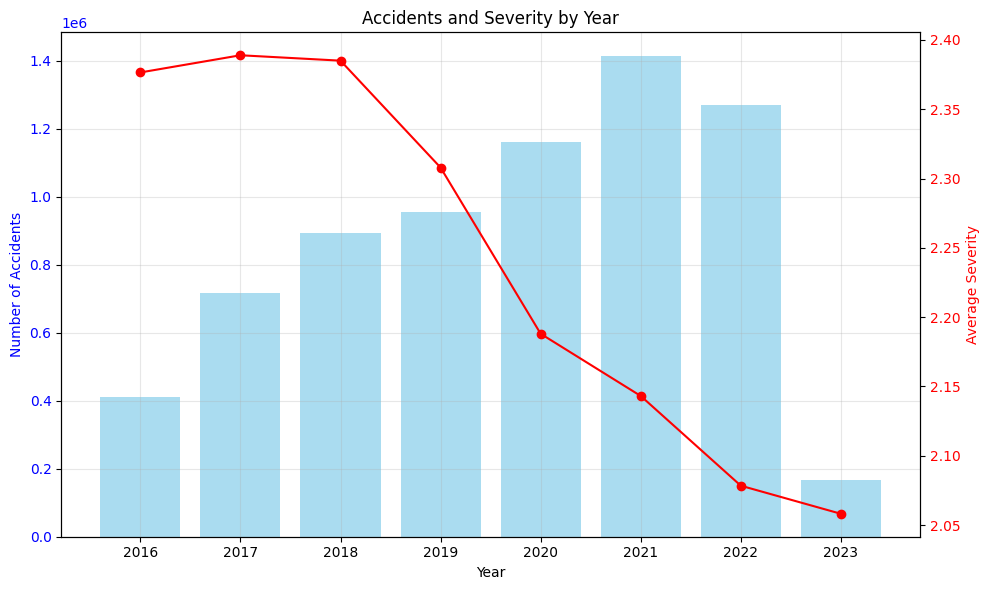

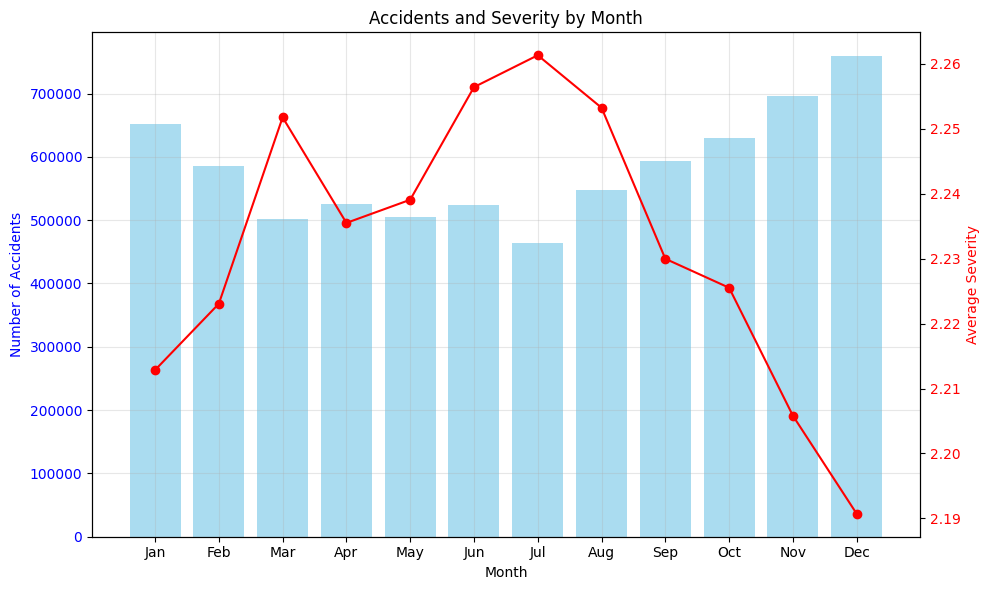

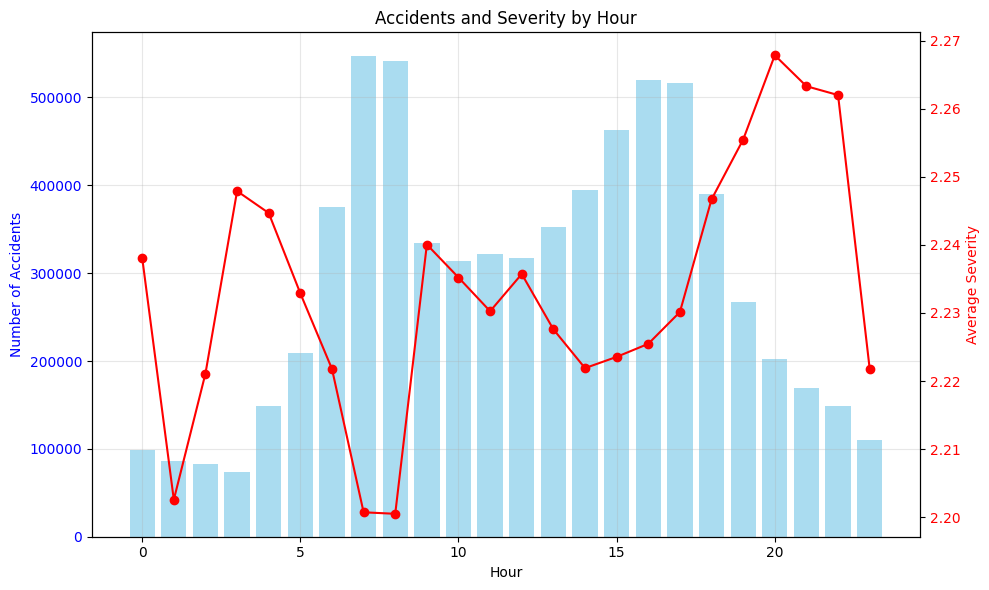

In [48]:
analyze_time_vs_severity_and_count(df)

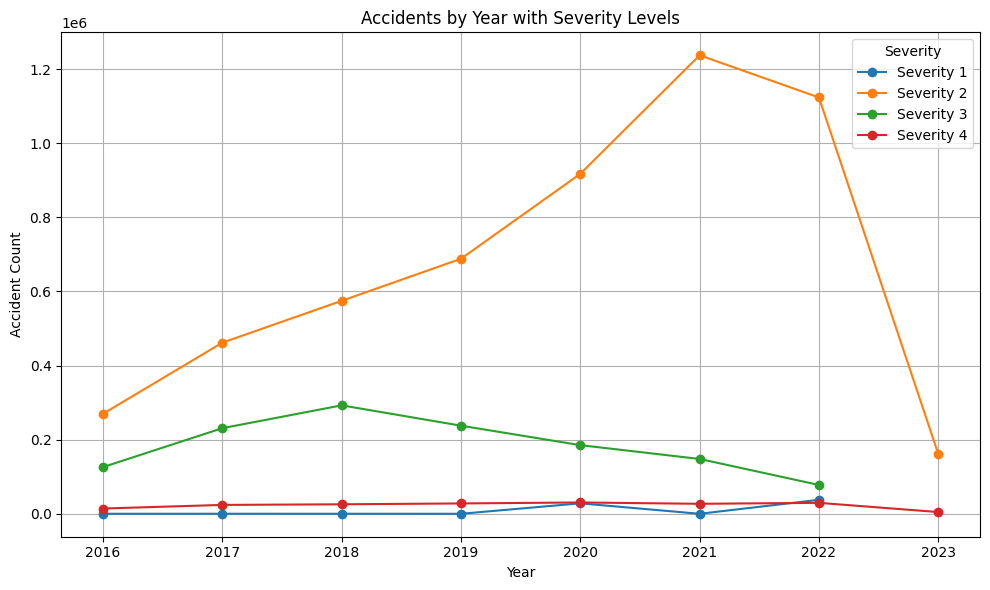

In [49]:
accident_by_year_severity(df)

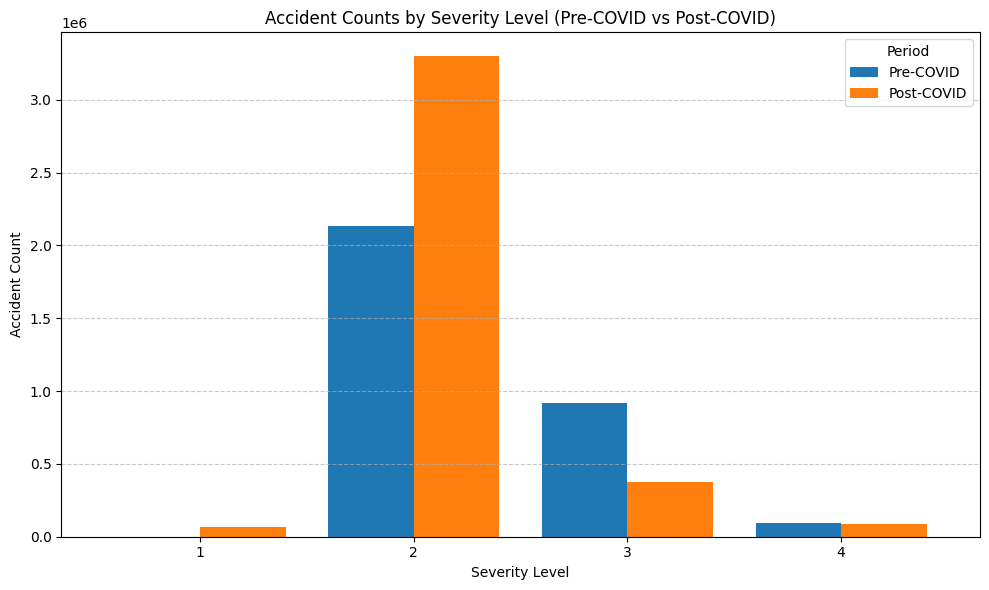

In [50]:
covid_analysis(df)

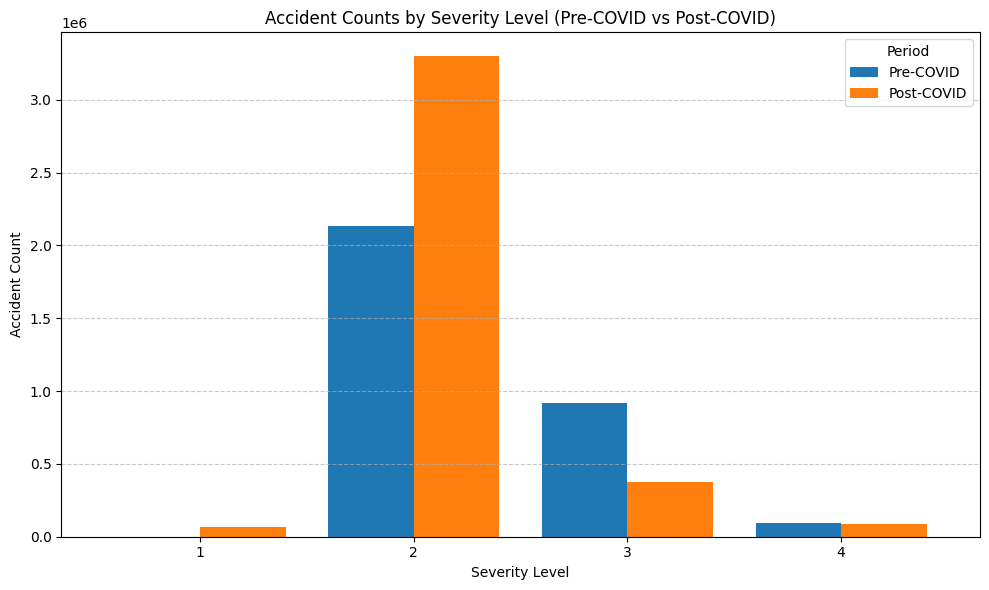

In [51]:
# Ensure 'Start_Time' is in datetime format and extract the year
df['Date_Of_Accident'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Date_Of_Accident'])  # Drop rows with invalid dates

# Define Pre-COVID and Post-COVID periods (March 2020)
df_pre_covid = df[df['Date_Of_Accident'] < '2020-03-01']
df_post_covid = df[df['Date_Of_Accident'] >= '2020-03-01']

# Aggregate counts by Severity for Pre-COVID and Post-COVID
pre_covid_counts = df_pre_covid['Severity'].value_counts().sort_index()
post_covid_counts = df_post_covid['Severity'].value_counts().sort_index()

# Create a DataFrame for easier plotting
severity_levels = range(1, 5)  # Severity levels 1 to 4
data = {
    'Pre-COVID': [pre_covid_counts.get(severity, 0) for severity in severity_levels],
    'Post-COVID': [post_covid_counts.get(severity, 0) for severity in severity_levels],
}
bar_df = pd.DataFrame(data, index=severity_levels)

# Plot a bar graph
bar_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Accident Counts by Severity Level (Pre-COVID vs Post-COVID)')
plt.xlabel('Severity Level')
plt.ylabel('Accident Count')
plt.xticks(rotation=0)
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


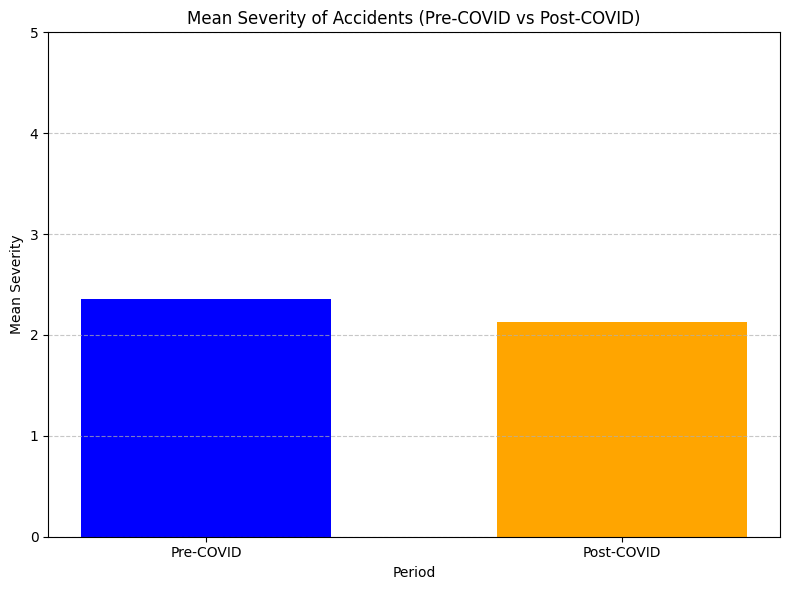

In [53]:
# Calculate the mean severity for Pre-COVID and Post-COVID periods
mean_severity_pre_covid = df_pre_covid['Severity'].mean()
mean_severity_post_covid = df_post_covid['Severity'].mean()

# Create a DataFrame for the mean severity values
mean_severity_data = {
    'Period': ['Pre-COVID', 'Post-COVID'],
    'Mean Severity': [mean_severity_pre_covid, mean_severity_post_covid]
}
mean_severity_df = pd.DataFrame(mean_severity_data)

# Plot the mean severity as a bar graph
plt.figure(figsize=(8, 6))
plt.bar(mean_severity_df['Period'], mean_severity_df['Mean Severity'], color=['blue', 'orange'], width=0.6)
plt.title('Mean Severity of Accidents (Pre-COVID vs Post-COVID)')
plt.xlabel('Period')
plt.ylabel('Mean Severity')
plt.ylim(0, 5)  # Assuming severity levels range from 1 to 4, this adds some padding
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Number of Pre-COVID Accidents: 3153724
Number of Post-COVID Accidents: 3831504


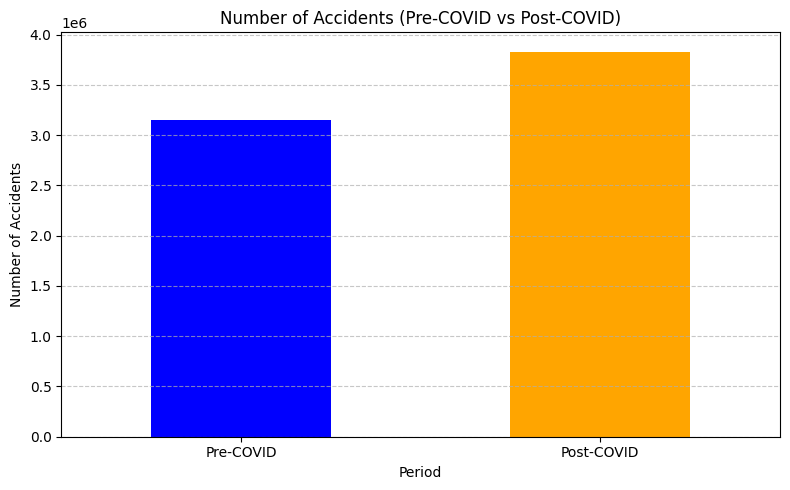

In [54]:
# Ensure 'Start_Time' is in datetime format and extract the date
df['Date_Of_Accident'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Date_Of_Accident'])  # Drop rows with invalid dates

# Define Pre-COVID and Post-COVID periods (March 2020)
df_pre_covid = df[df['Date_Of_Accident'] < '2020-03-01']
df_post_covid = df[df['Date_Of_Accident'] >= '2020-03-01']

# Count total accidents in each period
pre_covid_count = len(df_pre_covid)
post_covid_count = len(df_post_covid)

# Display the counts
print(f"Number of Pre-COVID Accidents: {pre_covid_count}")
print(f"Number of Post-COVID Accidents: {post_covid_count}")

# Plotting
data = {'Period': ['Pre-COVID', 'Post-COVID'], 'Accidents': [pre_covid_count, post_covid_count]}
plot_df = pd.DataFrame(data)


# Plot a bar graph
plot_df.plot(x='Period', y='Accidents', kind='bar', legend=False, figsize=(8, 5), color=['blue', 'orange'])
plt.title('Number of Accidents (Pre-COVID vs Post-COVID)')
plt.xlabel('Period')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Number of Pre-COVID Accidents: 3153724
Number of During Lockdown Accidents: 360687
Number of Post-COVID Accidents: 3470817


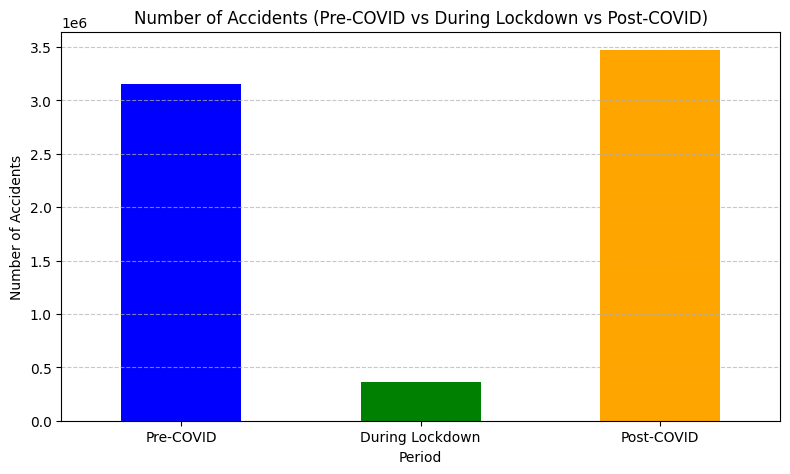

In [55]:
# Ensure 'Start_Time' is in datetime format and extract the date
df['Date_Of_Accident'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Date_Of_Accident'])  # Drop rows with invalid dates

# Define periods
lockdown_start = '2020-03-01'
lockdown_end = '2020-06-30'

df_pre_covid = df[df['Date_Of_Accident'] < lockdown_start]  # Pre-COVID
df_post_covid = df[df['Date_Of_Accident'] >= lockdown_end]  # Post-lockdown
df_during_lockdown = df[(df['Date_Of_Accident'] >= lockdown_start) & (df['Date_Of_Accident'] <= lockdown_end)]  # During lockdown

# Count total accidents in each period
pre_covid_count = len(df_pre_covid)
post_covid_count = len(df_post_covid)
during_lockdown_count = len(df_during_lockdown)

# Display the counts
print(f"Number of Pre-COVID Accidents: {pre_covid_count}")
print(f"Number of During Lockdown Accidents: {during_lockdown_count}")
print(f"Number of Post-COVID Accidents: {post_covid_count}")

# Prepare data for plotting
data = {
    'Period': ['Pre-COVID', 'During Lockdown', 'Post-COVID'],
    'Accidents': [pre_covid_count, during_lockdown_count, post_covid_count],
}
plot_df = pd.DataFrame(data)

# Plot a bar graph
plot_df.plot(x='Period', y='Accidents', kind='bar', legend=False, figsize=(8, 5), color=['blue', 'green', 'orange'])
plt.title('Number of Accidents (Pre-COVID vs During Lockdown vs Post-COVID)')
plt.xlabel('Period')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Pre-COVID Average Accidents per Day: 2567.29
During Lockdown Average Accidents per Day: 2956.45


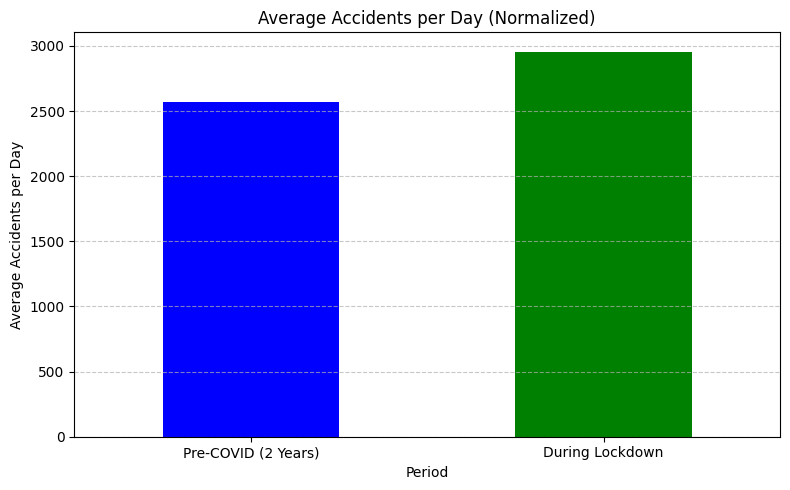

In [56]:
# Ensure 'Start_Time' is in datetime format
df['Date_Of_Accident'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Date_Of_Accident'])  # Drop rows with invalid dates

# Define periods
lockdown_start = pd.Timestamp('2020-03-01')
lockdown_end = pd.Timestamp('2020-06-30')
pre_covid_start = lockdown_start - pd.Timedelta(days=2*365)  # Two years before lockdown starts
pre_covid_end = lockdown_start - pd.Timedelta(days=1)  # Day before lockdown starts

# Filter data for each period
df_pre_covid = df[(df['Date_Of_Accident'] >= pre_covid_start) & (df['Date_Of_Accident'] <= pre_covid_end)]
df_during_lockdown = df[(df['Date_Of_Accident'] >= lockdown_start) & (df['Date_Of_Accident'] <= lockdown_end)]

# Count total accidents in each period
pre_covid_count = len(df_pre_covid)
during_lockdown_count = len(df_during_lockdown)

# Calculate the number of days in each period
pre_covid_days = (pre_covid_end - pre_covid_start).days + 1
lockdown_days = (lockdown_end - lockdown_start).days + 1

# Normalize accident counts
pre_covid_avg = pre_covid_count / pre_covid_days
during_lockdown_avg = during_lockdown_count / lockdown_days

# Display normalized data
print(f"Pre-COVID Average Accidents per Day: {pre_covid_avg:.2f}")
print(f"During Lockdown Average Accidents per Day: {during_lockdown_avg:.2f}")

# Prepare data for plotting
data = {
    'Period': ['Pre-COVID (2 Years)', 'During Lockdown'],
    'Average Accidents per Day': [pre_covid_avg, during_lockdown_avg],
}
plot_df = pd.DataFrame(data)

# Plot a bar graph
plot_df.plot(x='Period', y='Average Accidents per Day', kind='bar', legend=False, figsize=(8, 5), color=['blue', 'green'])
plt.title('Average Accidents per Day (Normalized)')
plt.xlabel('Period')
plt.ylabel('Average Accidents per Day')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [58]:
df = load_data_from_pickle(pickle_file_path)
# Replace I-5N and I5S with I05
df['Freeway'] = df['Freeway'].replace('I-5N', 'I-05')
df['Freeway'] = df['Freeway'].replace('I-5S', 'I-05')
def freeway_data(df):
    freeway_cols = ['Severity', 'Freeway', 'Is_Freeway', 'State', 'Start_Lat', 'Start_Lng']
    df = df[df['Is_Freeway']]
    df = df[freeway_cols]
    return df
df_freeway = freeway_data(df)

In [59]:
def highway_to_hell(df):
    counts = df.value_counts(['Freeway']).reset_index(name='Count')
    total_count = counts['Count'].sum()
    counts['Percentage'] = (counts['Count'] / total_count) * 100
    sorted_counts = counts.sort_values(by='Count', ascending=False)
    return sorted_counts[:25]


sorted_counts = highway_to_hell(df_freeway)


In [61]:
def freeway_maps(gdf_list, color_list):

    # Create a new plot with Cartopy
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add natural features like coastlines and borders
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    for gdf, color in zip(gdf_list, color_list):
        gdf.plot(ax=ax, color=color, alpha=0.5, markersize=1, transform=ccrs.PlateCarree())


    plt.title("Top 5 Haunted Freeways")
    plt.tight_layout()
    plt.show()

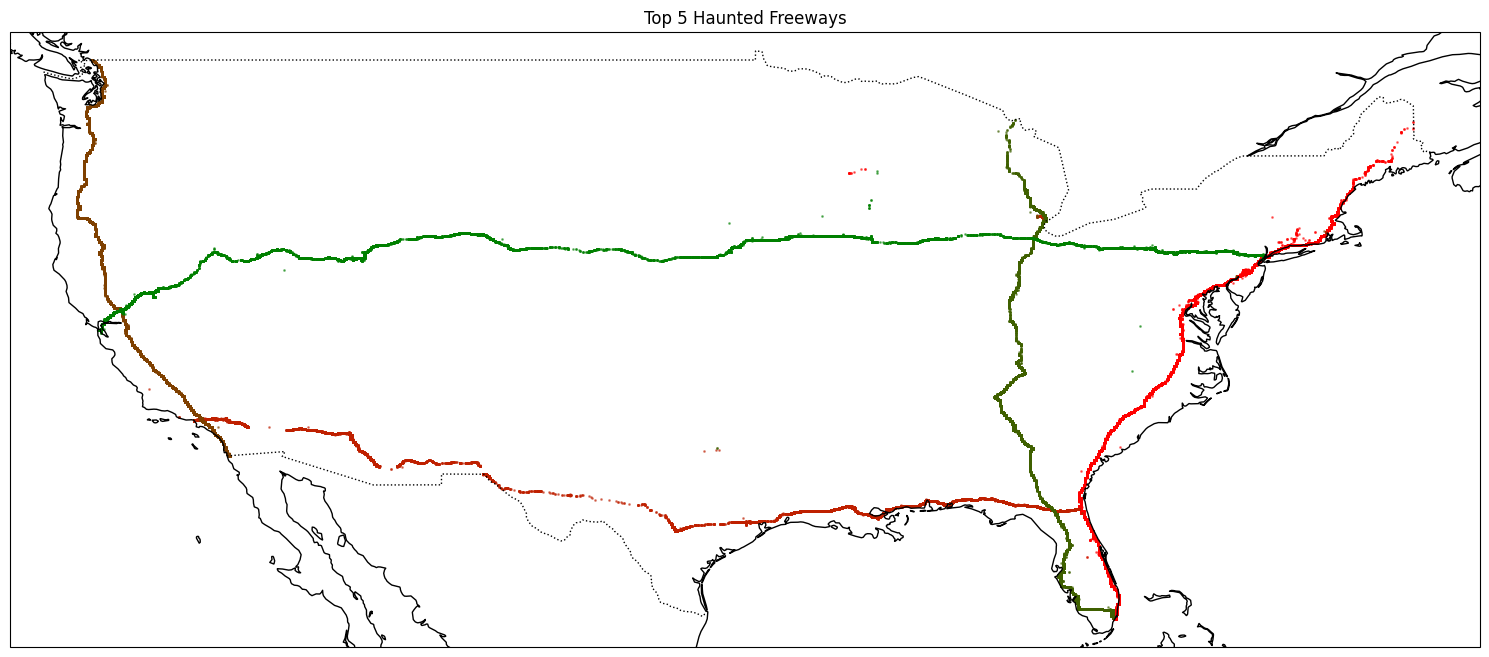

In [62]:
no_of_freeway_plots = 5

gfd_list = []
red_to_green = mcolors.LinearSegmentedColormap.from_list("RedGreen", ["red", "green"])
color_list = [red_to_green(i / (no_of_freeway_plots - 1)) for i in range(no_of_freeway_plots)]

for i in range(no_of_freeway_plots):
    assert i < 20
    df_temp = df_freeway[df_freeway['Freeway'] == sorted_counts.iloc[i, 0]]
    gfd = gpd.GeoDataFrame(df_temp, geometry=gpd.points_from_xy(df_temp['Start_Lng'], df_temp['Start_Lat']))
    gfd_list.append(gfd)

freeway_maps(gfd_list, color_list)

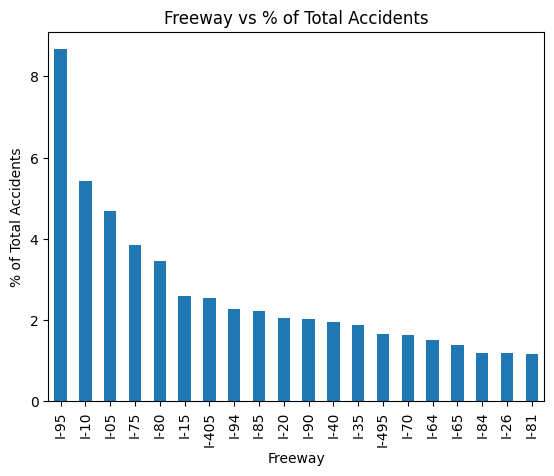

In [63]:
top_20_freeway = sorted_counts[:20]


top_20_freeway.plot(kind='bar', x='Freeway', y='Percentage', legend=False)

# Customize the plot
plt.title("Freeway vs % of Total Accidents")
plt.xlabel("Freeway")
plt.ylabel("% of Total Accidents")
plt.show()

In [64]:
def state_data(df):
    state_cols = ['Severity', 'State']
    df = df[state_cols]
    return df

df_state = state_data(df)


In [66]:
severity_counts = df_state.groupby(['State', 'Severity']).size().reset_index(name='Counts')

# Group by State to get total accidents (for sorting purposes)
total_accidents = severity_counts.groupby('State')['Counts'].sum().reset_index()
total_accidents = total_accidents.sort_values(by='Counts', ascending=False)

# Merge severity_counts with total_accidents to ensure the same order
severity_counts = severity_counts.merge(total_accidents, on='State', suffixes=('', '_Total'))

# Sort severity_counts by the total accident counts for consistent ordering
severity_counts = severity_counts.sort_values(by='Counts_Total', ascending=False)

# Define Severity as a categorical variable to ensure color ordering
severity_order = severity_counts.groupby('Severity')['Counts'].sum().sort_values(ascending=False).index.tolist()
severity_counts['Severity'] = pd.Categorical(severity_counts['Severity'], categories=severity_order, ordered=True)



In [67]:
state_population = {
    'AL': 5024279, 'AK': 733391, 'AZ': 7151502, 'AR': 3011524, 'CA': 39538223,
    'CO': 5773714, 'CT': 3605944, 'DE': 989948, 'FL': 21538187, 'GA': 10711908,
    'HI': 1455271, 'ID': 1839106, 'IL': 12812508, 'IN': 6785528, 'IA': 3190369,
    'KS': 2937880, 'KY': 4505836, 'LA': 4657757, 'ME': 1362359, 'MD': 6177224,
    'MA': 7029917, 'MI': 10077331, 'MN': 5706494, 'MS': 2961279, 'MO': 6154913,
    'MT': 1084225, 'NE': 1961504, 'NV': 3104614, 'NH': 1377529, 'NJ': 9288994,
    'NM': 2117522, 'NY': 20201249, 'NC': 10439388, 'ND': 779094, 'OH': 11799448,
    'OK': 3959353, 'OR': 4237256, 'PA': 13002700, 'RI': 1097379, 'SC': 5118425,
    'SD': 886667, 'TN': 6910840, 'TX': 29145505, 'UT': 3271616, 'VT': 643077,
    'VA': 8631393, 'WA': 7705281, 'WV': 1793716, 'WI': 5893718, 'WY': 576851,
    'DC': 689545
}

In [68]:
severity_counts['Population'] = severity_counts['State'].map(state_population)
severity_counts['Normalized_Count'] = (severity_counts['Counts_Total'] / severity_counts['Population']) * 100000


In [69]:
# Create the bar chart using Plotly Express
bar_fig = px.bar(
    severity_counts,
    x='State',
    y='Counts',
    color='Severity',
    title='Number of Accidents per Severity for Each State (Unnormalized)',
    color_continuous_scale='Viridis'
)

# Convert the Plotly Express figure to a go.Figure
fig = go.Figure(bar_fig)

# Add line graph
fig.add_trace(
    go.Scatter(
        x=severity_counts['State'],
        y=severity_counts['Normalized_Count'],
        mode='lines+markers',
        name='Total Counts Per Capita',
        line=dict(color='red', width=2),
        yaxis='y2'
    )
)

fig.update_layout(
    title="Statewise Accident Analysis",
    xaxis_title="State",
    yaxis_title="Counts (Accidents)",  # Left y-axis label for bar plot
    yaxis2=dict(
        title="Total Counts Per Capita",  # Right y-axis label for the line plot
        overlaying='y',  # This ensures the line plot uses a secondary y-axis
        side='right',  # Place secondary y-axis on the right
        showgrid=False  # Optionally remove grid lines from the secondary y-axis
    ),
    legend_title="Severity",
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Align legend at the bottom of the top boundary
        y=1.1,  # Position above the plot area
        xanchor="center",  # Center align the legend
        x=0.5  # Center the legend horizontally
    )
)
# Show the plot
fig.show()